<h1>Analysis and visualization of Olsen et al (2020; see https://github.com/tne-lab/Olsen-et-al-2020)</h1>
<h2>This script was written by Sarah Olsen and University of Minnesota (olsen378@umn.edu) from 2019 to 2020, largely taken from code originally written by Taha Bilge at MGH (taha.bilge@gmail.com)</h2>

In [ ]:
##Requires the following data files which can also be downloaded from https://github.com/tne-lab/Olsen-et-al-2020
#Figure 2 (Gantt chart code) uses: UH3-NS100548-01_PCS01_GanttChartData.xlsx
#Figure 4 (Clinical outcomes by day since operation) uses: UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv
#Figure 5 (MSIT RT) and correponding analysis uses: UH3-NS100548-01_PCS01_MSIT_Full.csv
#Figure 6 (Intraoperative WPLI) uses: UH3-NS100548-01_PCS01_IntraoperativeWPLI.csv
#Figure 7 (Saline recording, and daily LFP non artifact corrected and artifact subtracted power) uses: 
    #UH3-NS100548-01_PCS01_Saline_Power.csv
    #UH3-NS100548-01_PCS01_DailyLFP_NonCorrected_Power.csv
    #UH3-NS100548-01_PCS01_DailyLFP_Corrected_Power.csv
#Figure 8 (Saline recording, and daily LFP non artifact corrected and artifact subtracted WPLI) uses:
    #UH3-NS100548-01_PCS01_Saline_WPLI.csv
    #UH3-NS100548-01_PCS01_DailyLFP_NonCorrected_WPLI.csv
    #UH3-NS100548-01_PCS01_DailyLFP_Corrected_WPLI.csv
#Figure 10 (Clinical outcomes by WPLI correlations) uses: UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv
#Random forest analysis uses: UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv

In [1]:
#Load packages
#run me everytime
#import all the packages
import os #I think this has nice file and directory reading things
import re
import numpy as np #this has the array and some other aggregating functions
import matplotlib.pyplot as plt #this is for plots
import matplotlib.cm as cm
import seaborn as sns #data visualization based on matplotlib
import pandas as pd #pandas is a way to work with data frames
from collections import defaultdict 
from datetime import datetime #functions for working with date/time stamps
from numpy.polynomial.polynomial import polyfit
# from mne import make_fixed_length_events, Epochs, set_log_level, read_epochs, concatenate_raws
# from mne.connectivity import spectral_connectivity, seed_target_indices
# from mne.io import Raw
# from mne.time_frequency import tfr_array_morlet, tfr_multitaper, tfr_array_multitaper, psd_multitaper
from scipy import signal
from scipy.stats import sem, mode
from scipy.stats.stats import pearsonr
from sklearn import preprocessing

#set some seaborn plotting settings
sns.set(style='white', font_scale=1.5) #(from seaborn package) set how the output looks
set_log_level('critical') #set what mne outputs?
print('Done!')

Done!


<h2>Update the path to relevent directories!</h2>

In [14]:
#Update the directories!!!

data_dir = "C:\\Users\\TNEL - Human 2\\Desktop\\UH3-NS100548-01_PCS01_Analysis\\Data\\" ###UPDATE ME WITH CORRECT PATH TO DATA FOLDER

figure_dir = "C:\\Users\\TNEL - Human 2\\Desktop\\UH3-NS100548-01_PCS01_Analysis\\Figures\\" ###UPDATE ME WITH CORRECT PATH TO FIGURE FOLDER (WILL CREATE FOLDER IF IT DOESN'T EXIST)
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

<h1>Gantt Chart (Figure 2) Code</h1>
<h2>This section creates the gantt chart (Figure 2) that visualizes the timing of study events and settings changes.</h2>

In [26]:
gantt_file = data_dir+'UH3-NS100548-01_PCS01_GanttChartData.xlsx' 
print(gantt_file)
gantt_df = pd.read_excel(gantt_file, sheet_name = 0) #.read_excel is a pandas method that reads in the excel file as a pandas dataframe
print(gantt_df)

C:\Users\TNEL - Human 2\Desktop\UH3-NS100548-01_PCS01_Analysis\Data\UH3-NS100548-01_PCS01_GanttChartData.xlsx
             Item_Type                     Full_item  Start  End  \
0          Study Phase                   Study Phase     14  171   
1          Study Phase                   Study Phase    172  269   
2          Study Phase                   Study Phase    270  402   
3          Study Phase                   Study Phase    403  606   
4    Cortical Settings      Cortical Stim. Frequency    235  290   
5    Cortical Settings      Cortical Stim. Frequency    291  606   
6    Cortical Settings   Cortical Stim. Voltage Left    235  334   
7    Cortical Settings   Cortical Stim. Voltage Left    335  362   
8    Cortical Settings   Cortical Stim. Voltage Left    363  455   
9    Cortical Settings   Cortical Stim. Voltage Left    456  606   
10   Cortical Settings  Cortical Stim. Voltage Right    235  308   
11   Cortical Settings  Cortical Stim. Voltage Right    309  362   
12   C

In [27]:
#set file path (will need to update with your specific path)    
gantt_file = data_dir+'UH3-NS100548-01_PCS01_GanttChartData.xlsx' 

#read the file
gantt_df = pd.read_excel(gantt_file, sheet_name = 0) #.read_excel is a pandas method that reads in the excel file as a pandas dataframe
                                          #sheetname=None means that is will read in each sheet as its own key value pair in a dictionary

#get the clinic days for x axis labels
clinic_days = gantt_df.loc[gantt_df['Full_item'] == 'YBOCS']
clinic_days = list(clinic_days['Start']+1)

#change text to a string
gantt_df["text"] = gantt_df["Text"].astype(str)

#Make the text blank when nan
gantt_df.loc[gantt_df['text'] == 'nan', 'text'] = '' #have blank text when nan

gantt_df.loc[gantt_df['Item_Type'] == 'nan', 'Item Type'] = ''

#get the position of the text (center of the bars)
gantt_df['Position'] = gantt_df[['Start', 'End']].mean(axis=1)

print(len(clinic_days))
print('Done!')


39
Done!


In [28]:
#Create the Gantt chart (Figure 2) with timing of stimulation and recording settings as well as data collection 
import altair as alt #requires chrome driver to be installed and up to date with current version of chrome

alt.renderers.enable('notebook') # if in jupyter

chart = alt.Chart(gantt_df) #initialize the chart

#create the horizontal bars corresponding to study events, change their colors based on the type of event
bars = chart.mark_bar(clip=True).encode(
    x=alt.X('Start', axis=alt.Axis(title='Days Since Op', values=clinic_days, tickCount=len(clinic_days), labelAngle= -90, labelFontSize = 12,labelFontStyle='bold', labelOverlap = False), 
            scale=alt.Scale(domain=(13, 606), zero=False)),
    x2='End',
    y=alt.Y('Full_item', sort=list(gantt_df['Full_item']), axis=alt.Axis(title= None,labelFontSize=12, labelFontStyle='bold')),
    color=alt.Color('Item_Type',
                   scale=alt.Scale(
            domain=['Study Phase', 'Cortical Settings', 'VC/VS Settings', 'Data Collection'],
            range=['#313368', '#41448b', '#6366b6', '#babbde']), legend=None)
).properties(
    width=600,
    height=300
)

# Add text to the bars
text = alt.Chart(gantt_df).mark_text(clip=True, align='center', baseline='middle', color="white",  fontWeight="bold", size = 10).encode(
    y=alt.Y('Full_item', sort=list(gantt_df['Full_item'])),
    x=alt.X('Position', scale=alt.Scale(domain=(13, 606), zero=False)),
    text='text'
)
# Plot and save the figure
figure = alt.layer(bars, text)
#figure
figure.save(figure_dir+'Figure 2.png', scale_factor= 4.0)


<h1>Clinical outcomes by day since operation (Figure 4)</h1>

In [18]:
#Load the the file with the outcomes and features (created in pcs_analysis_and_visualization_01_06_2020)
outcomes_features_file_path = data_dir+'UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv'
    #set the file path for the outcome_features file file (may need to change if file path changes)
outcomes_features_df = pd.read_csv(outcomes_features_file_path, index_col=False) #load thefile as a pandas dataframe
print(outcomes_features_df.columns)
print('Done!')

Index(['YBOCS_01', 'YBOCS_01b', 'YBOCS_02', 'YBOCS_03', 'YBOCS_04', 'YBOCS_05',
       'YBOCS_06', 'YBOCS_06b', 'YBOCS_07', 'YBOCS_08',
       ...
       'right_ipsi_wpli_closestDayPreClinic_morning_Beta',
       'right_ipsi_wpli_closestDayPreClinic_morning_Gamma',
       'right_ipsi_wpli_closestDayPreClinic_afternoon_Theta',
       'right_ipsi_wpli_closestDayPreClinic_afternoon_Alpha',
       'right_ipsi_wpli_closestDayPreClinic_afternoon_Beta',
       'right_ipsi_wpli_closestDayPreClinic_afternoon_Gamma',
       'right_ipsi_wpli_closestDayPreClinic_evening_Theta',
       'right_ipsi_wpli_closestDayPreClinic_evening_Alpha',
       'right_ipsi_wpli_closestDayPreClinic_evening_Beta',
       'right_ipsi_wpli_closestDayPreClinic_evening_Gamma'],
      dtype='object', length=335)
Done!


In [19]:
def prepare_corr_data(df_full, outcome_name): 
    """Remove NaNs from df based on given clinical outcome and reset the index.""" 
    #drops the na's, if any from the full dataframe
    df = df_full.dropna(how='any', subset=[outcome_name])
    df.reset_index(inplace=True, drop = True) #resets the index
    return df

Done!


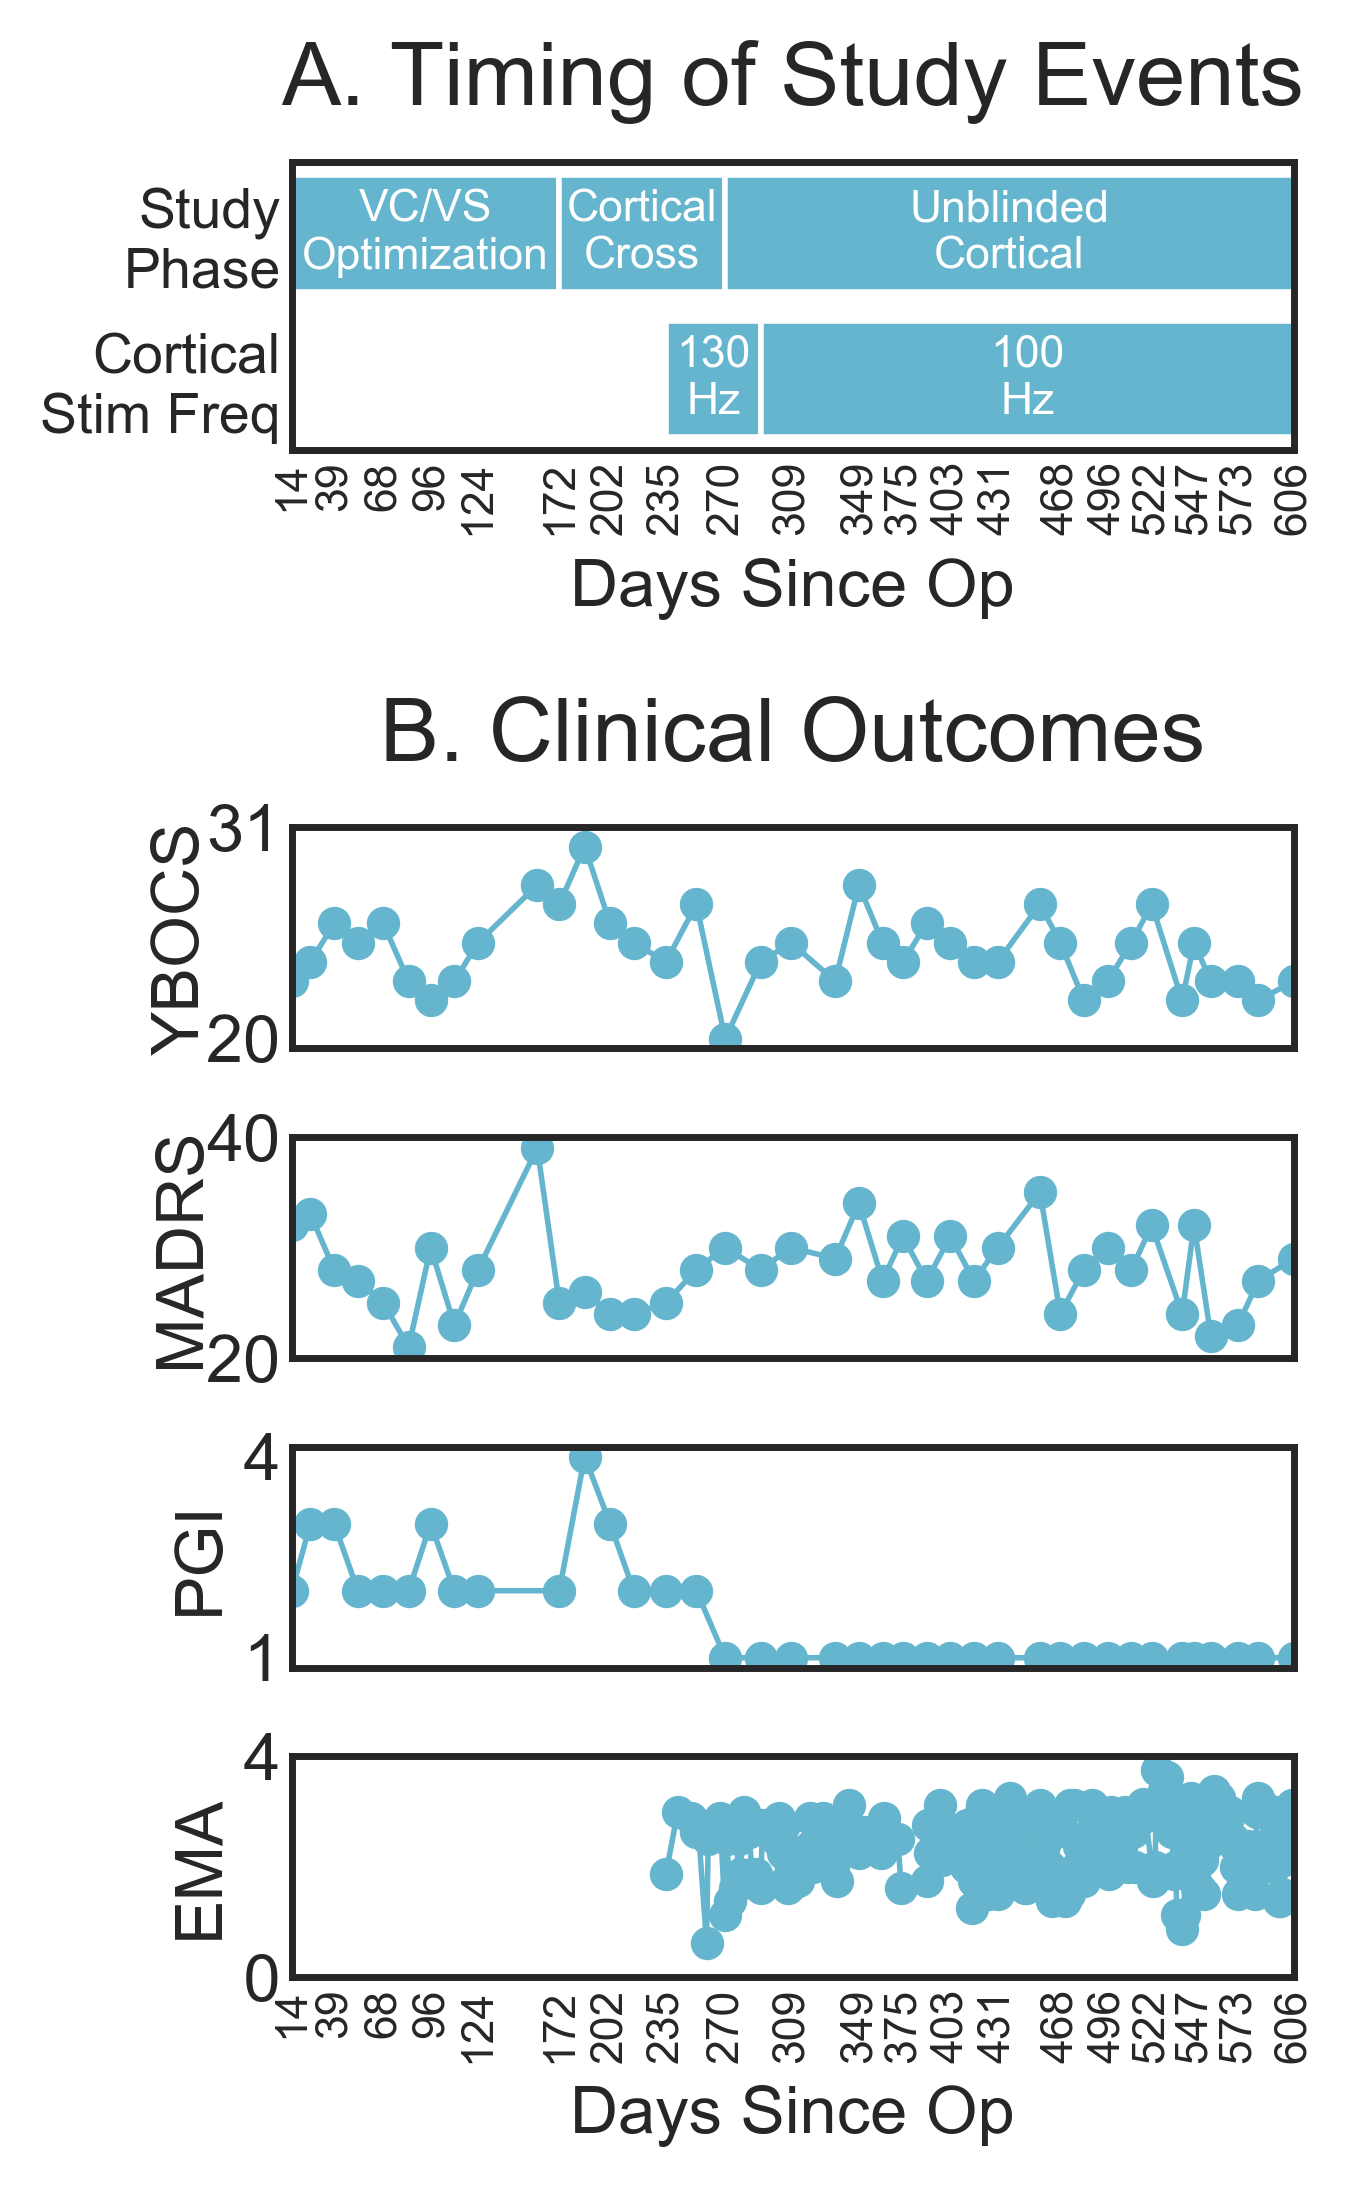

In [30]:
####Clinical outcomes by time (day since operation)- Figure 4
import matplotlib.gridspec as gridspec

xmin = 14 
xmax = 606 

ybocs_df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = 'YBOCS_total')

#create the figure object
fig = plt.figure( figsize=(3.34, 5.5), dpi=400) #create the figure object
gs = gridspec.GridSpec(2, 1, figure=fig, height_ratios = [.2, .8], bottom=0.1, top=0.925, left=0.2, right=0.95, hspace=0.525)
         #grid spec allows to create nested subplots, I think it creates a gridspec opject, not technically an axis/subplot

#############################
####Important study events###
#############################
#mini gantt chart with timing of certian study phases
gs_studyphase = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[0, 0]) #create a subplot within the gridspec

#create and axis for the study phase title
ax_studyphase_Title = fig.add_subplot(gs_studyphase[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_studyphase_Title.set_xticks([])
ax_studyphase_Title.set_yticks([])
plt.text(0.5, 1.2, 'A. Timing of Study Events',
         horizontalalignment='center',
         fontsize=16,
         transform = ax_studyphase_Title.transAxes)

#Study phase axis
ax_studyphase_00 = fig.add_subplot(gs_studyphase[0, 0]) #create the subplots (axis objects) to put the figures in 
ax = ax_studyphase_00

y_names = ['Cortical\nStim Freq','Study\nPhase']
texts = [['130\nHz', '100\nHz'],['VC/VS\nOptimization', 'Cortical\nCross', 'Unblinded\nCortical']]
widths = [[56, 315], [158, 98, 336]]
starts = [[235, 291], [14, 172, 270]]
centers = [[263, 448.5], [93, 221, 438]]

for jx, y_name in enumerate(y_names):
    ax.barh(y=y_name, width= widths[jx], left=starts[jx], height=.8, color='c')
    for ix, text in enumerate(texts[jx]):
        ax.text(x=centers[jx][ix], y=y_name, s=texts[jx][ix], ha='center', va='center', color='w', fontsize = 8)
    
ax.set_xlabel('Days Since Op', fontsize=12)
ax.set_xticks(ybocs_df['Days Since Op'][0:len(ybocs_df['Days Since Op'].index):2]) #set the x-axis ticks to the days since op column in the ybocs sheet
ax.set_xticklabels(ybocs_df['Days Since Op'][0:len(ybocs_df['Days Since Op'].index):2], fontsize=8) #set the x tick labels
ax.set_xlim(xmin, xmax) #set the x limits to be those set above
for tick in ax.get_xticklabels(): #rotate the x-tick labels by 90 degrees
    tick.set_rotation(90)
ax.set_yticklabels(['Cortical\nStim Freq', 'Study\nPhase'], fontsize=10) #set the x tick labels
ax.tick_params(axis='both', which='major', pad=-4)

########################
####Clinical Outcomes###
########################
gs_co = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs[1, 0], hspace = 0.4)

ax_co_Title = fig.add_subplot(gs_co[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_co_Title.set_xticks([])
ax_co_Title.set_yticks([])
plt.text(0.5, 1.3, 'B. Clinical Outcomes',
         horizontalalignment='center',
         fontsize=16,
         transform = ax_co_Title.transAxes)

#create the subplots (axis objects) to put the figures in
ax_co_00 = fig.add_subplot(gs_co[0, 0])  #YBOCS
ax_co_10 = fig.add_subplot(gs_co[1, 0])  #MADRS
ax_co_20 = fig.add_subplot(gs_co[2, 0])  #PGI
ax_co_30 = fig.add_subplot(gs_co[3, 0])  #EMA

#make variables to be used in the loop
ax_list = [ax_co_00, ax_co_10, ax_co_20 , ax_co_30]
y_names = ['YBOCS_total', 'MADRS_total', 'PGI', 'Summary Score']
y_labels = ['YBOCS', 'MADRS', 'PGI', 'EMA']
y_lims = [[20, 31], [20, 40], [1, 4], [0, 4]]
y_ticklabels = [[20, 31], [20, 40], [' 1', ' 4'], [' 0', ' 4']]

#loop to make the plots for each clinical outcome
for ix, ax in enumerate(ax_list):
    df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = y_names[ix])
    ax.plot(df['Days Since Op'],df[y_names[ix]], 'c-o', markersize = 5, linewidth= 1) #.plot is a matploylib method for plotting
                                                    #arguments here are (x, y, fmt), fmt = format = fmt = '[color][line][marker]', in this case
    ax.set_ylabel(y_labels[ix], fontsize=12, labelpad=-1) #set the y axis label
    ax.set_yticks(y_lims[ix]) #set the y-axis ticks
    ax.set_yticklabels(y_ticklabels[ix], fontsize=12) #set the y-axis tick labels
    ax.set_xlim(xmin, xmax) #set the x-axis limits (set above)

    if y_labels[ix] == 'EMA': #if the significance values is greater than 0.01, then 
        ax.set_xlabel('Days Since Op', fontsize=12)
        ax.set_xticks(ybocs_df['Days Since Op'][0:len(ybocs_df['Days Since Op'].index):2]) #set the x-axis ticks to the days since op column in the ybocs sheet
        ax.set_xticklabels(ybocs_df['Days Since Op'][0:len(ybocs_df['Days Since Op'].index):2], fontsize=8) #set the x tick labels
        for tick in ax.get_xticklabels(): #rotate the x-tick labels by 90 degrees
            tick.set_rotation(90)
    else:
        ax.set_xticks([])
    
    ax.tick_params(axis='both', which='major', pad=-4)

filename = 'Figure 4.jpg'  #all times
plt.savefig(figure_dir + filename)
print('Done!')

<h1>MSIT Response time figure (Figure 5) and linear regressions</h1>
<h2>This section provides the analysis for the multi source interference task data, collected approximately every three months</h2>

In [21]:
#read in the data file
data_file_path = data_dir+'UH3-NS100548-01_PCS01_MSIT_Full.csv' 
    #set the file path for the data file
behav_file = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe
print('Done!')

Done!


In [32]:
###remove the trials that should be excluded for analysis
# trials will be removed if:
        #The RT for the trial had a less than 0.005 percent chance of falling within a fitted gamma distribution
        #They responded incorrectly (error trials)
        #They responded incorrectly in the previous trial (post-error trials)

behav_excludeRem = behav_file.loc[behav_file['Exclude'] == 0] 
behav_excludeRem.reset_index(inplace=True, drop=True)

<h2>Plot MSIT RT data (Figure 5)</h2>

In [33]:
###These are the means used in the figure
#Get the mean response times day day since op and condition
group_cols = [ 'DaySinceOp','stim_cond_striatal_nonOpt_asRef']
metric_cols = ['ResponseTime']
aggragate_df = behav_excludeRem.groupby(group_cols, as_index= False)[metric_cols].mean()
print(aggragate_df)

   DaySinceOp stim_cond_striatal_nonOpt_asRef  ResponseTime
0          13         A_StriatalOnly_nonOptim      0.676004
1         104            B_StriatalOnly_Optim      0.588304
2         216            B_StriatalOnly_Optim      0.603383
3         335                      C_Combined      0.575688
4         448                      C_Combined      0.552493


['stim_cond_striatal_nonOpt_asRef', 'A_StriatalOnly_nonOptim', 'B_StriatalOnly_Optim', 'C_Combined']


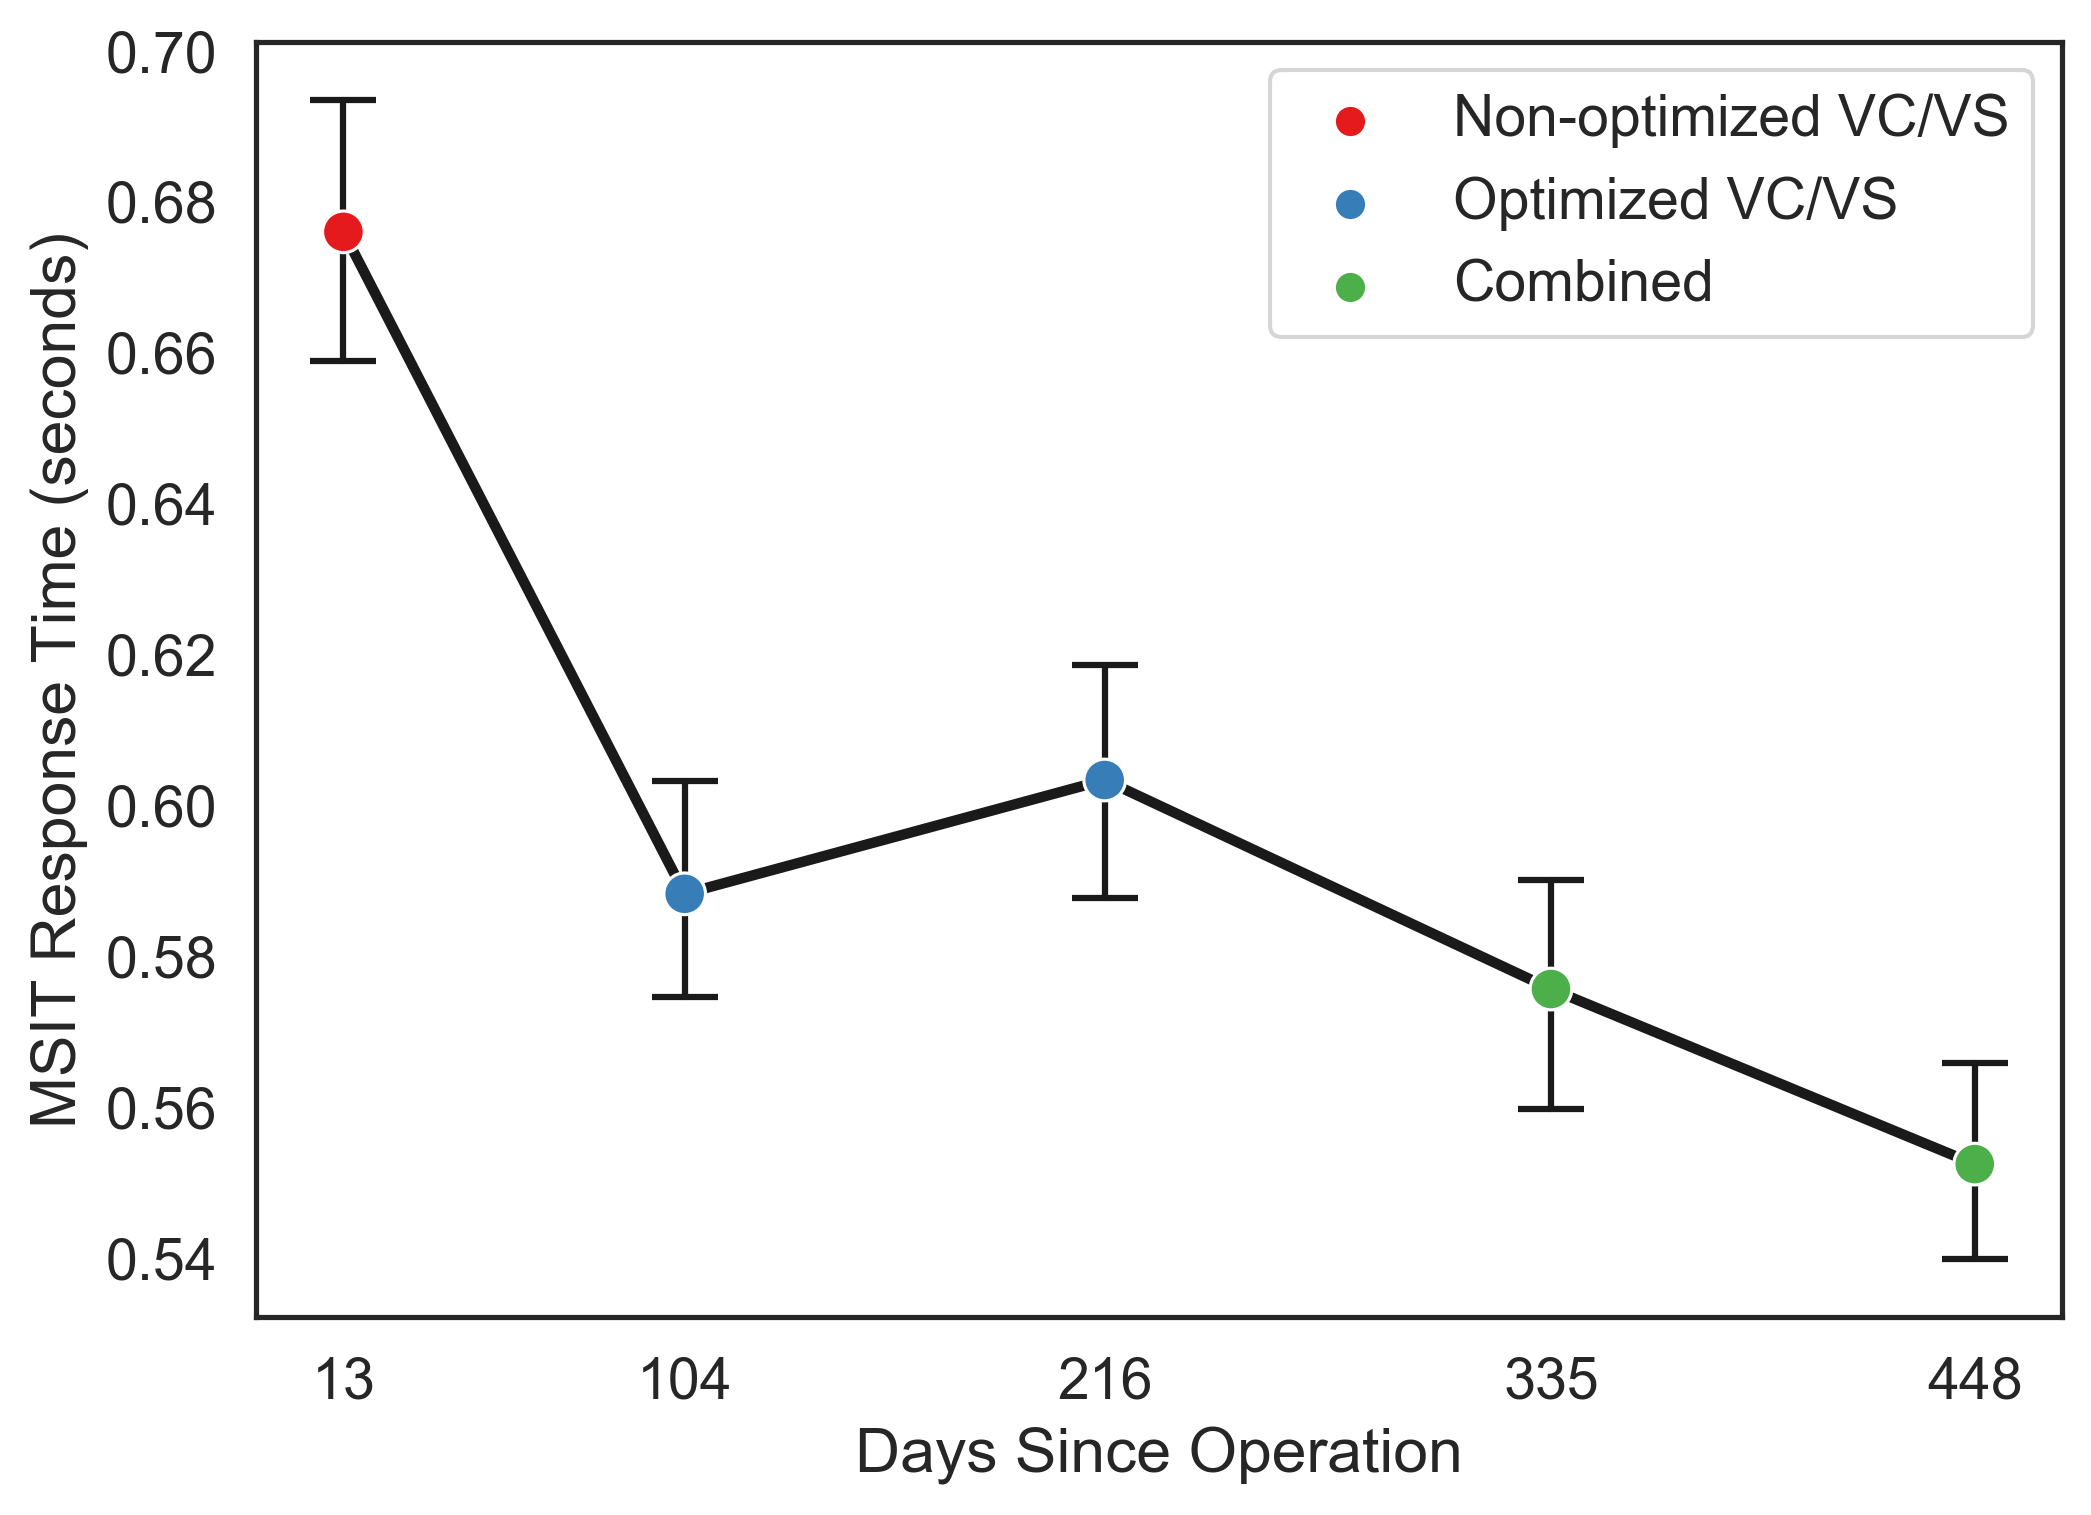

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt #this is for plots
import matplotlib.cm as cm
import matplotlib.colors as colors

sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5}) #set the seaborn figure context

#create the figure an axis objects
fig = plt.figure(figsize=(7.08, 5), dpi=300)
ax = fig.add_axes([.125, .125, .85, .85])

#line plot which draws black lines with error bars
ax = sns.lineplot(x="DaySinceOp", y="ResponseTime",  data=behav_excludeRem, markers="",err_style='bars', color="k", err_kws={'capsize':8, 'capthick':1.5, 'elinewidth':1.5})

#draws the dots colored based on the stimulation condition
ax = sns.scatterplot(x="DaySinceOp", y="ResponseTime", hue= "stim_cond_striatal_nonOpt_asRef", data=aggragate_df, s=100, palette = 'Set1')

#I believe this puts the dots on top of the lines?
ax.lines[0].set_zorder(2)
for l  in ax.lines[1:]:
    l.set_zorder(5)
for c  in ax.collections:
    c.set_zorder(3)

#set some plot parameters   
ax.set_ylabel('MSIT Response Time (seconds)')
ax.set_xlabel('Days Since Operation')
ax.set_xticks(aggragate_df['DaySinceOp']) #set the x-axis ticks to the days since op column in the ybocs sheet
ax.set_xticklabels(aggragate_df['DaySinceOp']) #set the x tick labels
handles, labels = ax.get_legend_handles_labels()
print(labels)
l = plt.legend(handles[1:4], ['Non-optimized VC/VS', 'Optimized VC/VS', 'Combined'])

plt.savefig(figure_dir+'Figure 5.jpeg')

<h2>GLM with gamma distribution predicting MSIT RT</h2>

In [35]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
gamma_model_full = smf.glm(formula = 'ResponseTime ~ stim_cond + conflict_cond + DaySinceOp', data=behav_excludeRem, family=sm.families.Gamma(sm.families.links.identity()))
gamma_results_full = gamma_model_full.fit()

print(gamma_results_full.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ResponseTime   No. Observations:                 1790
Model:                            GLM   Df Residuals:                     1785
Model Family:                   Gamma   Df Model:                            4
Link Function:               identity   Scale:                        0.034956
Method:                          IRLS   Log-Likelihood:                 1499.7
Date:                Fri, 18 Sep 2020   Deviance:                       57.809
Time:                        12:20:40   Pearson chi2:                     62.4
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [37]:
#conflict and stim condition condition only
gamma_model_noDay = smf.glm(formula = 'ResponseTime ~ conflict_cond + stim_cond', data=behav_excludeRem, family=sm.families.Gamma(sm.families.links.identity()))
gamma_results_noDay = gamma_model_noDay.fit()

print(gamma_results_noDay.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ResponseTime   No. Observations:                 1790
Model:                            GLM   Df Residuals:                     1786
Model Family:                   Gamma   Df Model:                            3
Link Function:               identity   Scale:                        0.035010
Method:                          IRLS   Log-Likelihood:                 1498.4
Date:                Fri, 18 Sep 2020   Deviance:                       57.890
Time:                        12:20:44   Pearson chi2:                     62.5
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------
Inte

C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [39]:
#conflict and day only
gamma_model_noStimCond = smf.glm(formula = 'ResponseTime ~ conflict_cond + DaySinceOp', data=behav_excludeRem, family=sm.families.Gamma(sm.families.links.identity()))
gamma_results_noStimCond = gamma_model_noStimCond.fit()

print(gamma_results_noStimCond.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:           ResponseTime   No. Observations:                 1790
Model:                            GLM   Df Residuals:                     1787
Model Family:                   Gamma   Df Model:                            2
Link Function:               identity   Scale:                        0.035906
Method:                          IRLS   Log-Likelihood:                 1473.8
Date:                Fri, 18 Sep 2020   Deviance:                       59.503
Time:                        12:20:50   Pearson chi2:                     64.2
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept       

C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:273: DomainWarning: The identity link function does not respect the domain of the Gamma family.
  DomainWarning)


In [40]:
from scipy import stats

def calculate_nested_f_statistic(small_model, big_model):
    """Given two fitted GLMs, the larger of which contains the parameter space of the smaller, return the F Stat and P value corresponding to the larger model adding explanatory power"""
    addtl_params = big_model.df_model - small_model.df_model
    f_stat = (small_model.deviance - big_model.deviance) / (addtl_params * big_model.scale)
    df_numerator = addtl_params
    # use fitted values to obtain n_obs from model object:
    df_denom = (big_model.fittedvalues.shape[0] - big_model.df_model)
    p_value = stats.f.sf(f_stat, df_numerator, df_denom)
    return (f_stat, p_value)

In [41]:
Day = calculate_nested_f_statistic(gamma_results_noDay, gamma_results_full)
print('Day adding predicitve power', Day)

Stim = calculate_nested_f_statistic(gamma_results_noStimCond, gamma_results_full)
print('Stim condition adding predictive power', Stim)

Day adding predicitve power (2.3202710553105774, 0.12787480618153735)
Stim condition adding predictive power (24.23296832160603, 4.130662600306762e-11)


<h1>Intraoperative cortical-striatal WPLI (Figure 6)</h1>
<h2>This sections creates the figure of introperative cortical-striatal WPLI at different depths of VC/VS.</h2>

In [22]:
#Read in the intraoperative coherence file
data_file_path = data_dir+'UH3-NS100548-01_PCS01_IntraoperativeWPLI.csv' 

intropWPLI_df = pd.read_csv(data_file_path, index_col=False) 

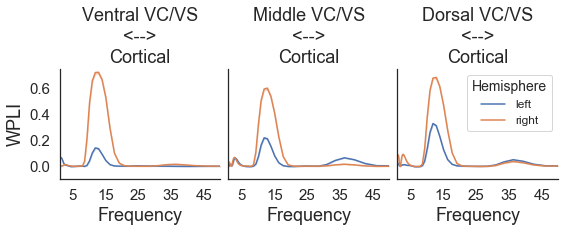

In [46]:
#non artifact corrected PSDs
directory = "C:\\Users\\TNEL - Human 2\\Desktop\\UH3-NS100548-01_PCS01_Analysis\\Figures\\"

sns.set(style='white', font_scale=1.5) #(from seaborn package) set how the output looks

fig = sns.FacetGrid(data = intropWPLI_df, col = 'Striatal Location', hue = 'Hemisphere', ylim = (-0.1,0.75), xlim=(1, 50), aspect=1)
fig.map(sns.lineplot, 'Frequency', 'WPLI') 
fig.set_titles('{col_name}\n<-->\nCortical', fontsize=18) 
fig.set(xticks=[5, 15, 25, 35, 45], yticks=[0.0, 0.2, 0.4, 0.6])
fig.set_yticklabels([0.0, 0.2, 0.4, 0.6], size = 15)
fig.set_xticklabels([5, 15, 25, 35, 45], size = 15)
fig.axes[0, 2].legend(title = 'Hemisphere', title_fontsize= 14, fontsize = 12)#bbox_to_anchor =(x, y, width, height)
fig.fig.subplots_adjust(wspace=.05, hspace=.05)
file_name = 'Figure 6.jpg'
fig.savefig(directory+file_name, dpi = 400)

<h1>Power (Figure 7) and WPLI (Figure 8) for the saline recording, and the daily LFP patient recordings before and after subtraction of the saline artifacts</h1>

In [24]:
data_file_path = data_dir+'UH3-NS100548-01_PCS01_Saline_Power.csv' 
saline_power = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

data_file_path = data_dir+'UH3-NS100548-01_PCS01_DailyLFP_NonCorrected_Power.csv' 
power_df_nonCorrected = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

data_file_path = data_dir+'UH3-NS100548-01_PCS01_DailyLFP_Corrected_Power.csv' 
power_df = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

data_file_path = data_dir+'UH3-NS100548-01_PCS01_Saline_WPLI.csv' 
saline_WPLI = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

data_file_path = data_dir+'UH3-NS100548-01_PCS01_DailyLFP_NonCorrected_WPLI.csv' 
coh_df_nonCorrected = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

data_file_path = data_dir+'UH3-NS100548-01_PCS01_DailyLFP_Corrected_WPLI.csv' 
coh_df = pd.read_csv(data_file_path, index_col=False) #load the metadata file as a pandas dataframe

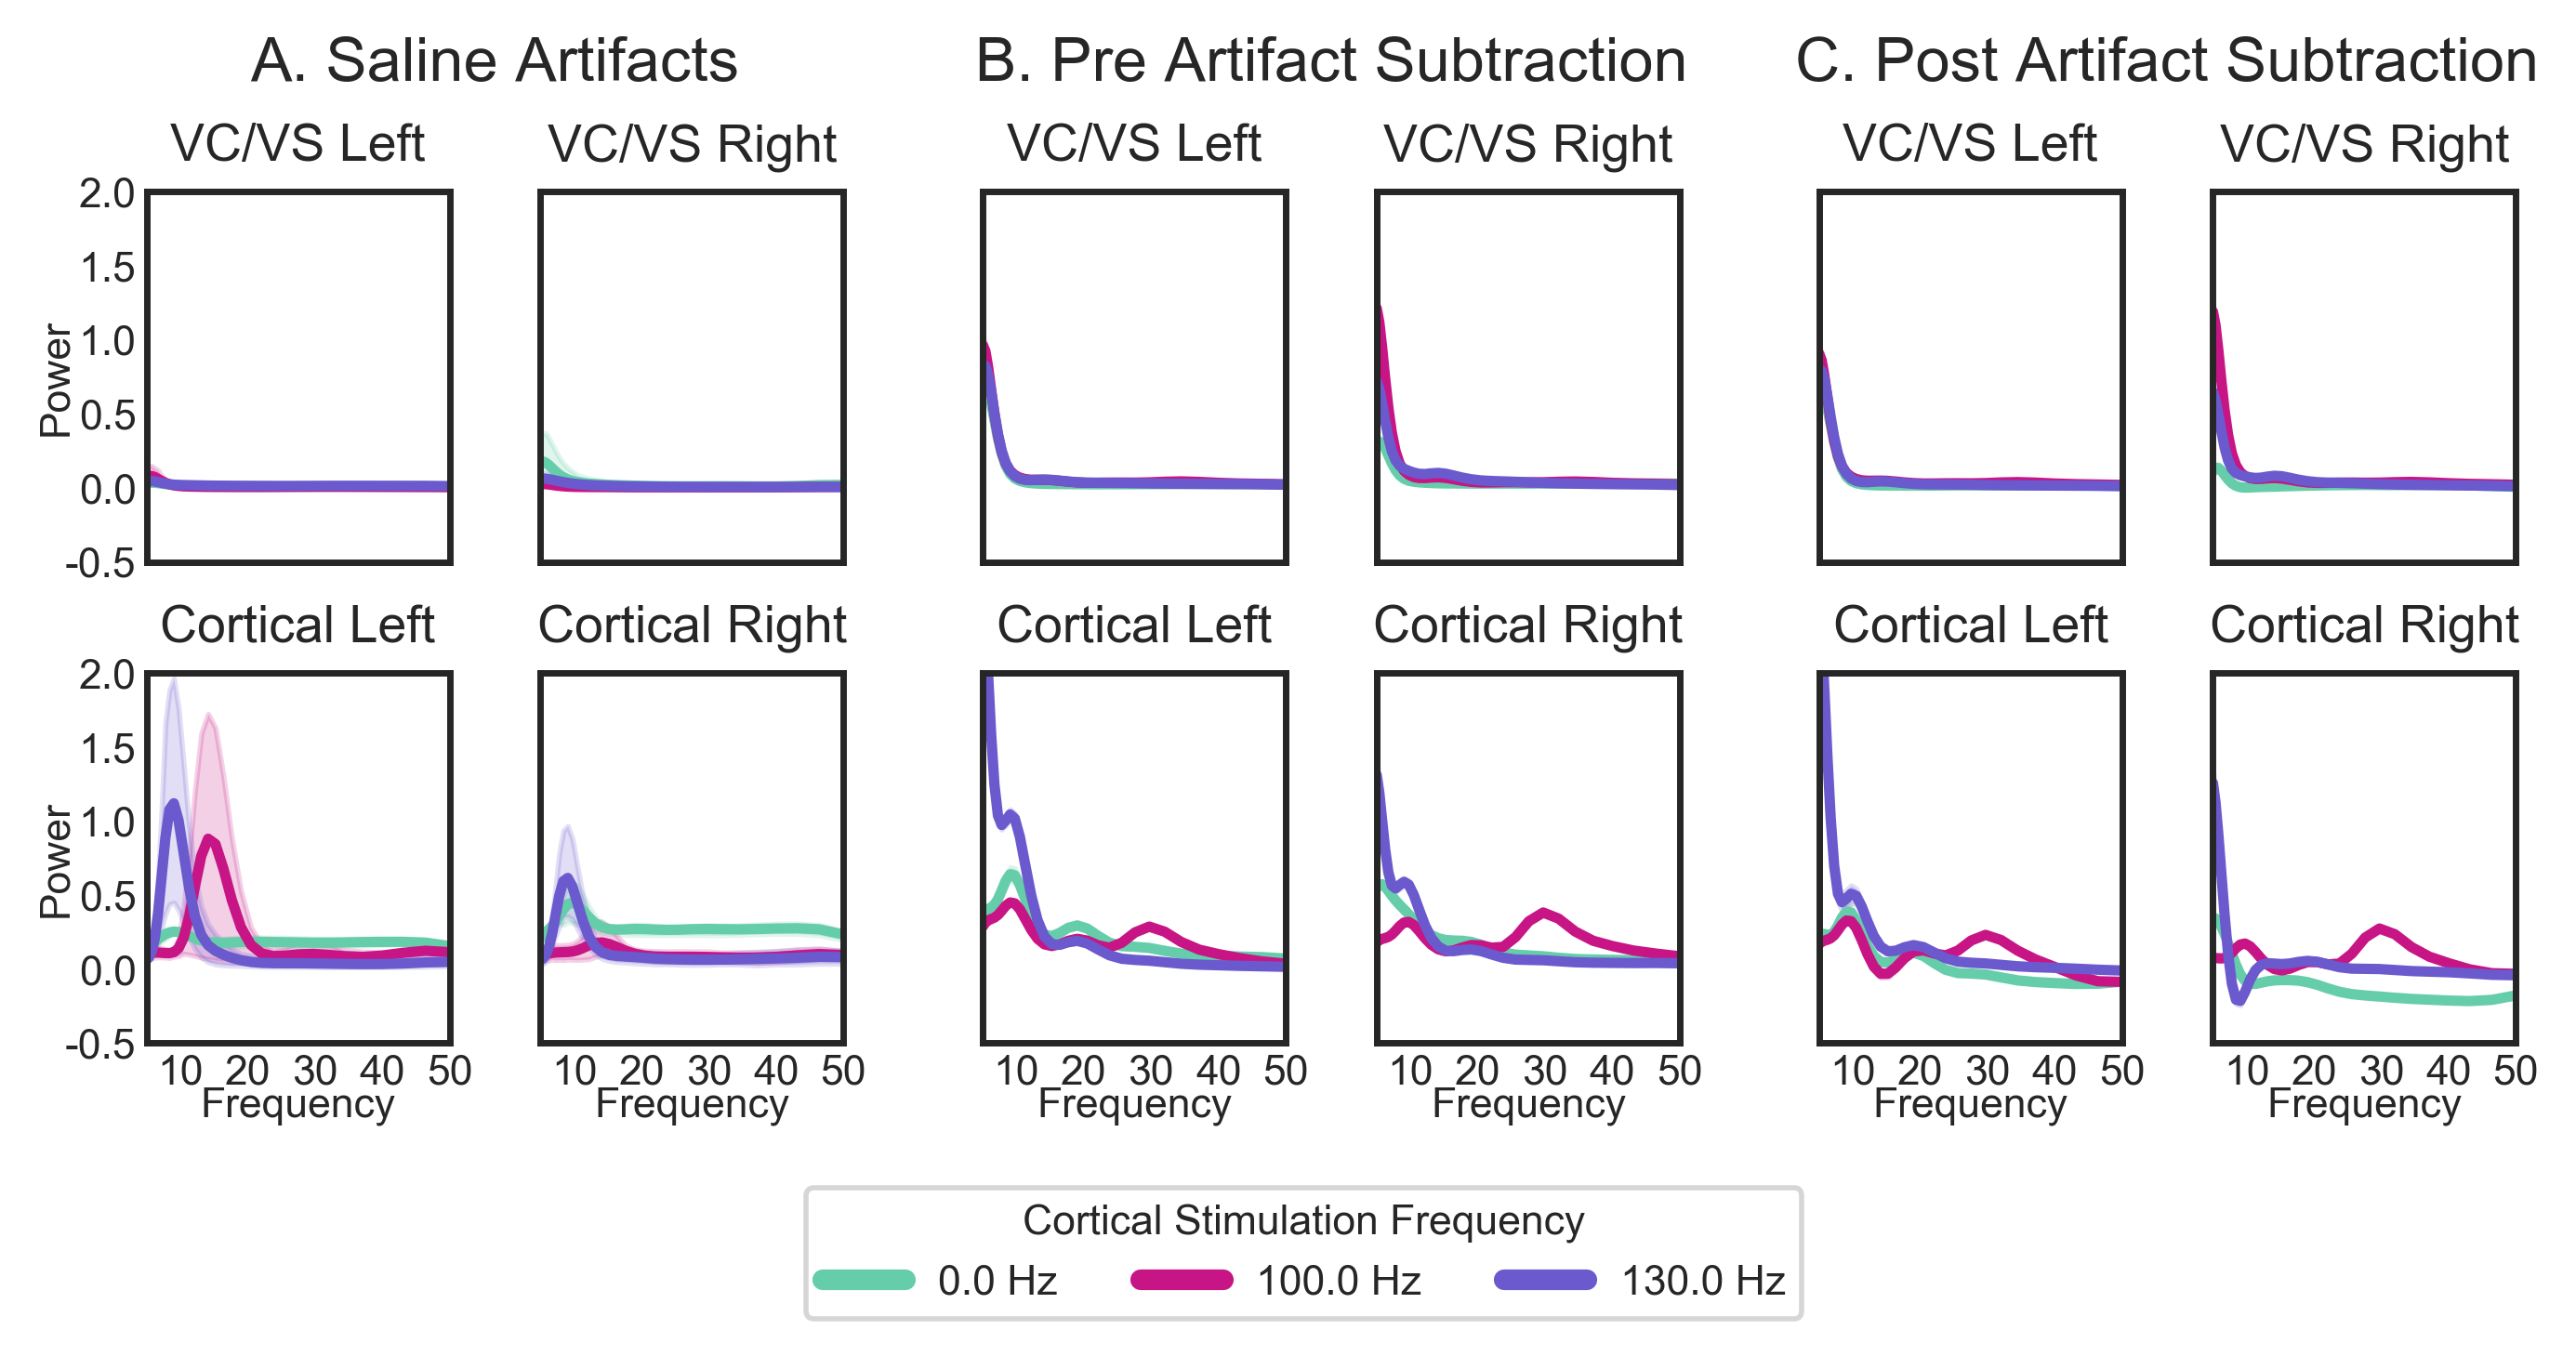

In [13]:
#######PSDs for artifact, pre-subtracted, and artifact corrected patient recordings (Figure 7)
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7.08, 4), dpi=400) #create the figure object

gs = gridspec.GridSpec(2, 3, figure=fig, height_ratios = [.9, .1], bottom=0.15, top=0.85, left=0.05, right=.95)

#####################
#####Artifact signal figures###
#####################
gs_artifact = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 0], hspace=0.3, wspace=0.3)

ax_artifact_Title = fig.add_subplot(gs_artifact[0, :], frameon=False)
ax_artifact_Title.set_xticks([])
ax_artifact_Title.set_yticks([])

plt.text(0.5, 1.3, 'A. Saline Artifacts',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_artifact_Title.transAxes)

ax_artifact_00 = fig.add_subplot(gs_artifact[0, 0])
ax_artifact_01 = fig.add_subplot(gs_artifact[0, 1])
ax_artifact_10 = fig.add_subplot(gs_artifact[1, 0])
ax_artifact_11 = fig.add_subplot(gs_artifact[1, 1])

channel = 'VC/VS Left'
ax =ax_artifact_00
artifact_pow = saline_power.loc[saline_power['Channel'] == 'SL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Freq String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = artifact_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10)  
ax.set_xlabel('')
ax.set_xticks([])
positions = (-0.5, 0.0, 0.5, 1.0, 1.5, 2.0)
labels = (-0.5, 0.0, 0.5, 1.0, 1.5, 2.0)
ax.set_ylabel('Power', fontsize = 8, labelpad=-2)
ax.set_yticks(positions)
ax.set_yticklabels(labels, fontsize=8)
ax.tick_params(axis='both', which='major', pad=-4)
        

channel = 'VC/VS Right'
ax = ax_artifact_01
artifact_pow = saline_power.loc[saline_power['Channel'] == 'SR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Freq String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = artifact_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])


channel = 'Cortical Left'
ax = ax_artifact_10
artifact_pow = saline_power.loc[saline_power['Channel'] == 'CL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Freq String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'},data = artifact_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
positions = (-0.5, 0.0, 0.5, 1.0, 1.5, 2.0)
labels = (-0.5, 0.0, 0.5, 1.0, 1.5, 2.0)
ax.set_ylabel('Power', fontsize = 8, labelpad=-2)
ax.set_yticks(positions)
ax.set_yticklabels(labels, fontsize=8)
ax.tick_params(axis='both', which='major', pad=-4)


channel = 'Cortical Right'
ax = ax_artifact_11
artifact_pow = saline_power.loc[saline_power['Channel'] == 'CR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Freq String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = artifact_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)

plt.tight_layout

#####################
#####Non corrected signal figures###
#####################
gs_nonCor = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 1], hspace=0.3, wspace=0.3)

ax_nonCor_Title = fig.add_subplot(gs_nonCor[0, :], frameon=False)
ax_nonCor_Title.set_xticks([])
ax_nonCor_Title.set_yticks([])

plt.text(0.5, 1.3, 'B. Pre Artifact Subtraction',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_nonCor_Title.transAxes)

ax_nonCor_00 = fig.add_subplot(gs_nonCor[0, 0])
ax_nonCor_01 = fig.add_subplot(gs_nonCor[0, 1])
ax_nonCor_10 = fig.add_subplot(gs_nonCor[1, 0])
ax_nonCor_11 = fig.add_subplot(gs_nonCor[1, 1])


channel = 'VC/VS Left'
ax =ax_nonCor_00
nonCor_pow = power_df_nonCorrected.loc[power_df_nonCorrected["Channel Name"] == 'SL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = nonCor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10)  
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])
        

channel = 'VC/VS Right'
ax = ax_nonCor_01
nonCor_pow = power_df_nonCorrected.loc[power_df_nonCorrected["Channel Name"] == 'SR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = nonCor_pow, ax = ax,legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])


channel = 'Cortical Left'
ax = ax_nonCor_10
nonCor_pow = power_df_nonCorrected.loc[power_df_nonCorrected["Channel Name"] == 'CL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = nonCor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)

channel = 'Cortical Right'
ax = ax_nonCor_11
nonCor_pow = power_df_nonCorrected.loc[power_df_nonCorrected["Channel Name"] == 'CR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = nonCor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)


#####################
#####corrected signal figures###
#####################
gs_Cor = gridspec.GridSpecFromSubplotSpec(2, 2, subplot_spec=gs[0, 2], hspace=0.3, wspace=0.3)

ax_Cor_Title = fig.add_subplot(gs_Cor[0, :], frameon=False)
ax_Cor_Title.set_xticks([])
ax_Cor_Title.set_yticks([])

plt.text(0.5, 1.3, 'C. Post Artifact Subtraction',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_Cor_Title.transAxes)

ax_Cor_00 = fig.add_subplot(gs_Cor[0, 0])
ax_Cor_01 = fig.add_subplot(gs_Cor[0, 1])
ax_Cor_10 = fig.add_subplot(gs_Cor[1, 0])
ax_Cor_11 = fig.add_subplot(gs_Cor[1, 1])


channel = 'VC/VS Left'
ax =ax_Cor_00
Cor_pow = power_df.loc[power_df["Channel Name"] == 'SL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = Cor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10)   
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])        

channel = 'VC/VS Right'
ax = ax_Cor_01
Cor_pow = power_df.loc[power_df["Channel Name"] == 'SR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = Cor_pow, ax = ax, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
ax.set_xlabel('')
ax.set_xticks([])
ax.set_ylabel('')
ax.set_yticks([])


channel = 'Cortical Left'
ax = ax_Cor_10
Cor_pow = power_df.loc[power_df["Channel Name"] == 'CL']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String', hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = Cor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)


channel = 'Cortical Right'
ax = ax_Cor_11
Cor_pow = power_df.loc[power_df["Channel Name"] == 'CR']
ax = sns.lineplot(x='Frequency', y= 'Power', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = Cor_pow, ax = ax, legend = False, lw = 2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.5, 2.0)
ax.set_title(channel, fontsize=10) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize = 8, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=8)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)

#get the legend (last figure need to have the axis)
handles, labels = ax_Cor_01.get_legend_handles_labels()
ax_pos = ax_nonCor_Title.get_position() # get the original position 
legend_bbox = [-3.5, -2.1, 1, 0.2]
legend = ax_Cor_01.legend(handles=handles[1:], labels=labels[1:], title="Cortical Stimulation Frequency",fontsize=8,title_fontsize=8, loc = 'lower center', ncol=3, markerscale=3, bbox_to_anchor=legend_bbox)
for line in legend.get_lines():
    line.set_linewidth(4.0)

filename = 'Figure 9'  
plt.savefig(figure_dir + filename)

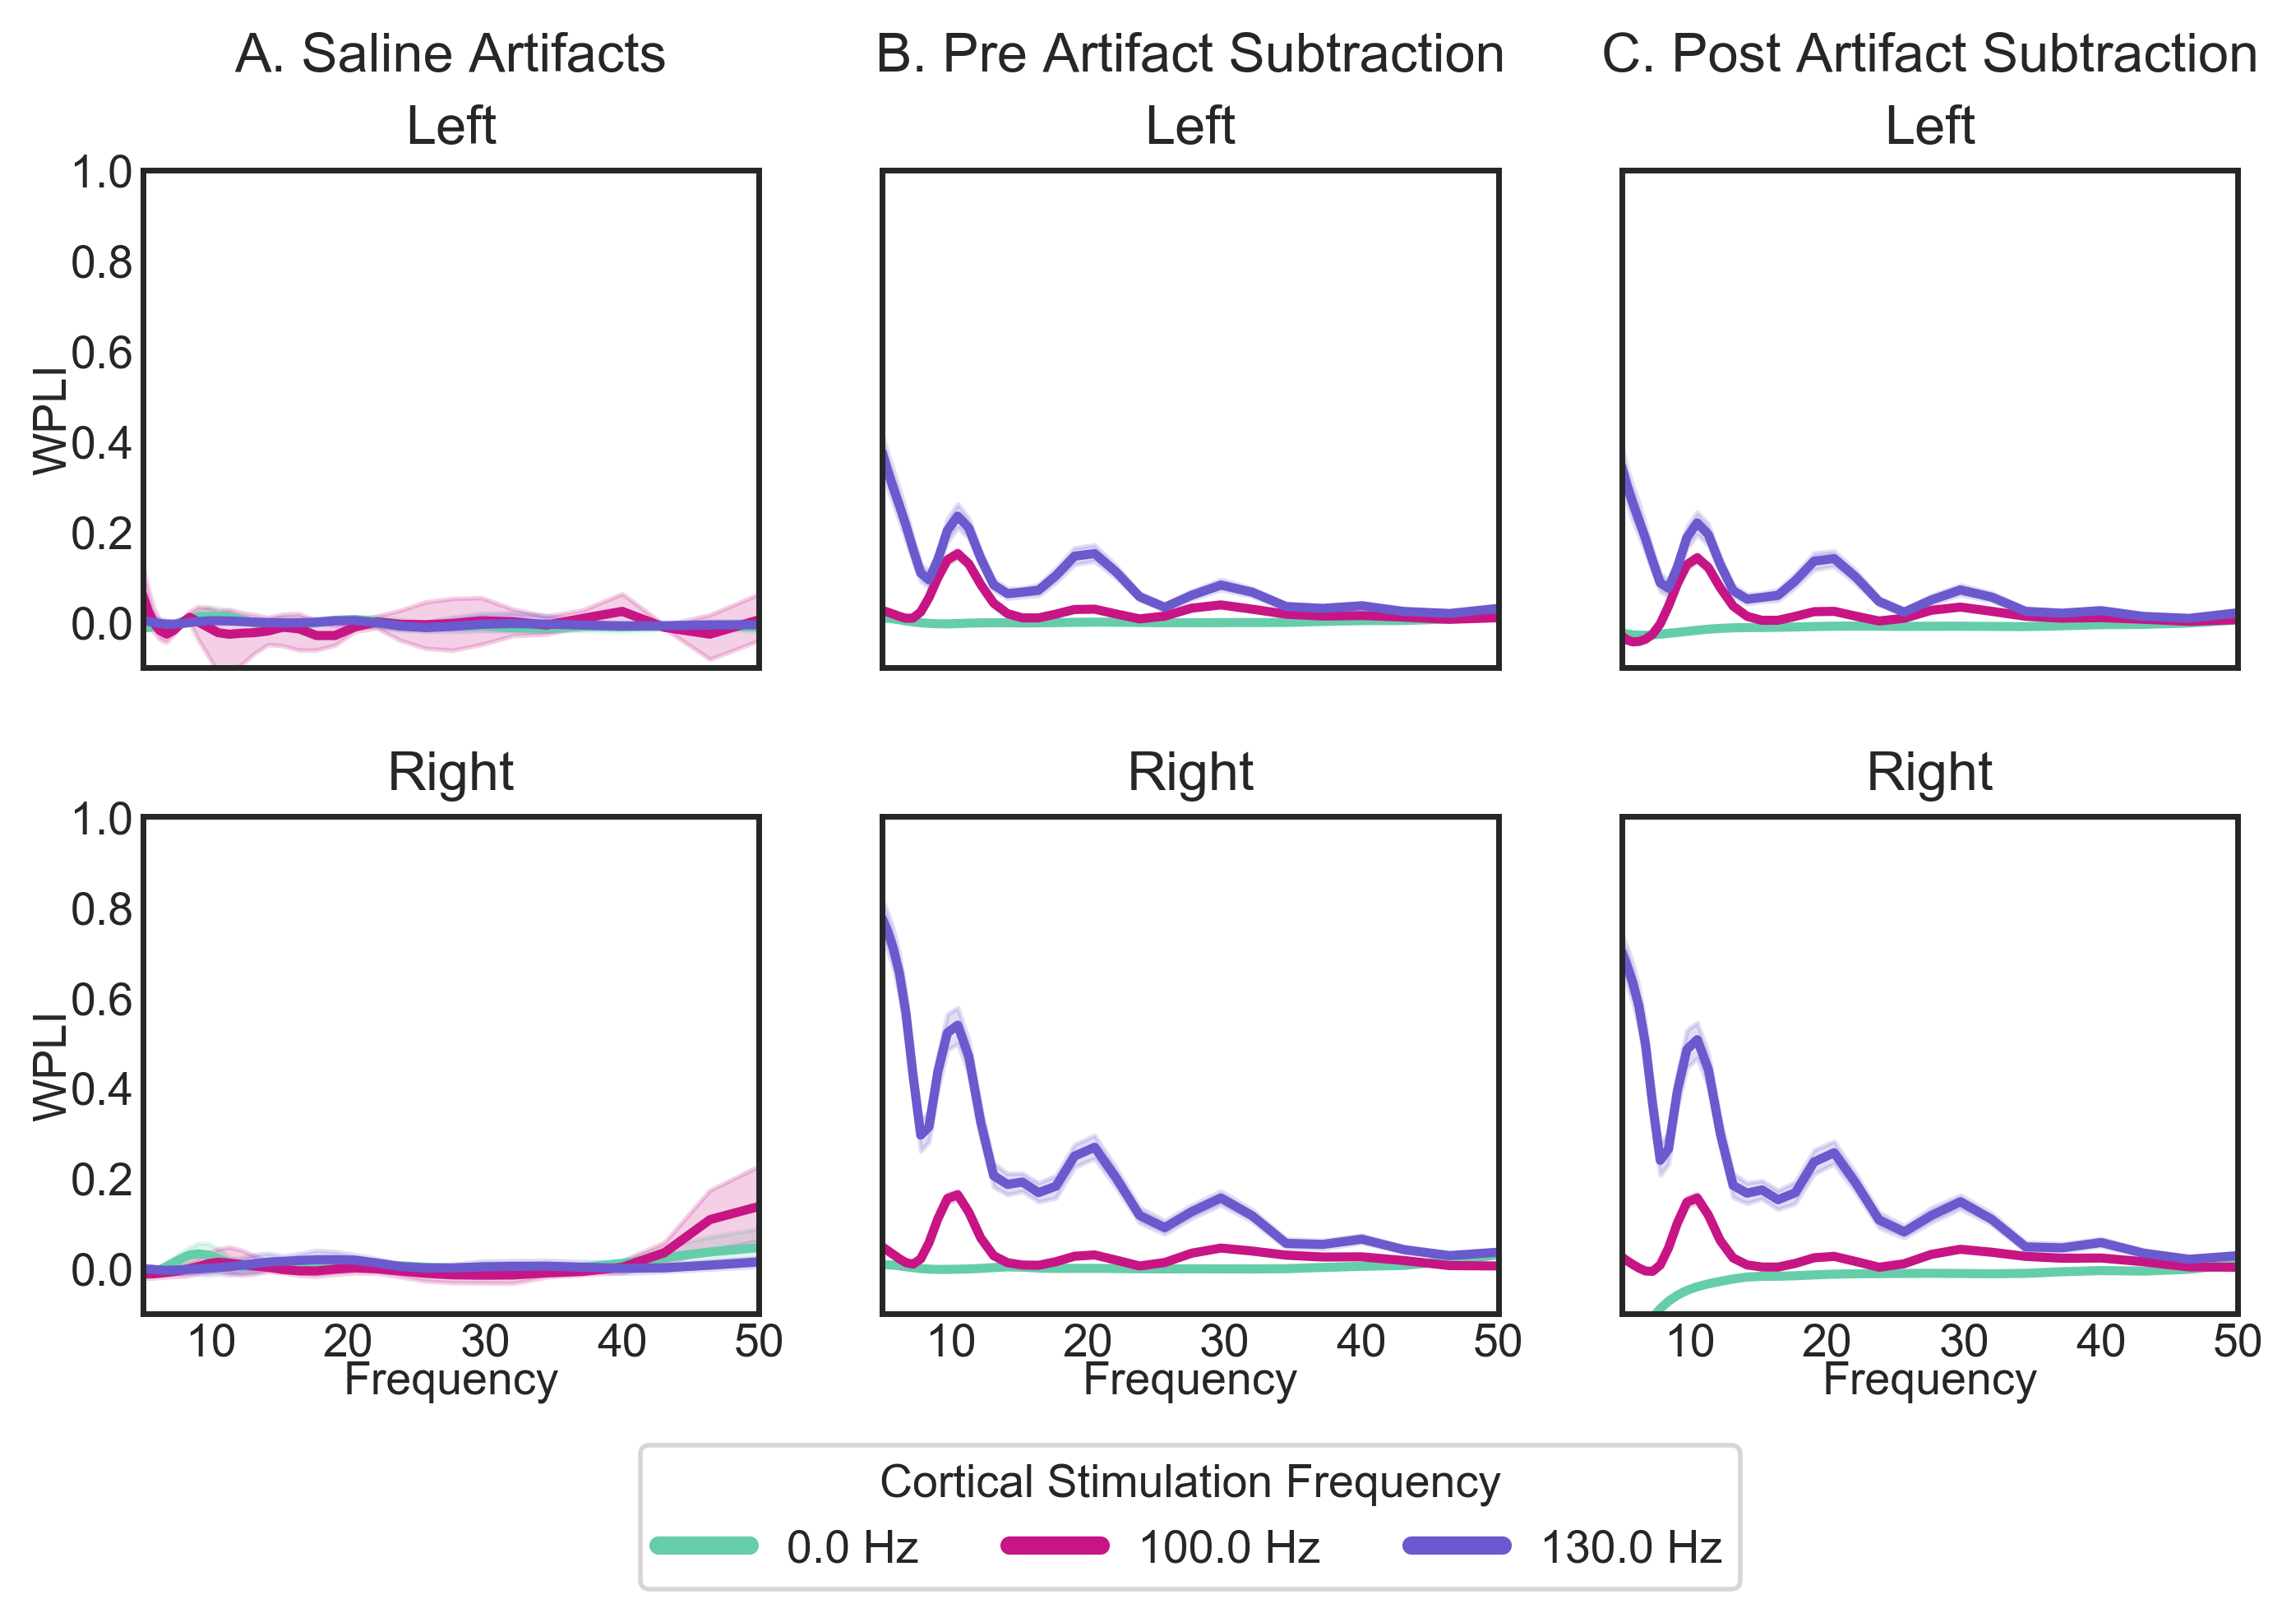

In [11]:
#Saline artifact, pre subtracted, and artifact subtracted WPLI (Figure 8)
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(7.08, 5), dpi=400) #create the figure object

gs = gridspec.GridSpec(2, 3, figure=fig, bottom=0.05, top=0.9, left=0.05, right=0.95, height_ratios = [.9, .1 ])

#####################
#####Artifact signal figures###
#####################
gs_artifact = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 0], hspace=0.3)

ax_artifact_Title = fig.add_subplot(gs_artifact[0, :], frameon=False)
ax_artifact_Title.set_xticks([])
ax_artifact_Title.set_yticks([])

plt.text(0.5, 1.2, 'A. Saline Artifacts',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_artifact_Title.transAxes)

ax_artifact_00 = fig.add_subplot(gs_artifact[0, 0])
ax_artifact_10 = fig.add_subplot(gs_artifact[1, 0])

channel = 'Left'
ax =ax_artifact_00
artifact_pow = saline_WPLI.loc[saline_WPLI['Hemisphere'] == 'Left']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Freq String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = artifact_pow, ax = ax, legend = False, lw=2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12)  
ax.set_xlabel('')
ax.set_xticks([])
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_yticks(positions)
ax.set_yticklabels(labels, fontsize=10)
ax.set_ylabel('WPLI', fontsize=10, labelpad=-1)
ax.tick_params(axis='both', which='major', pad=-4)

        

channel = 'Right'
ax = ax_artifact_10
artifact_pow = saline_WPLI.loc[saline_WPLI['Hemisphere'] == 'Right']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Freq String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'],palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = artifact_pow, ax = ax, legend = False, lw=2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize=10, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=10)
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_yticks(positions)
ax.set_yticklabels(labels, fontsize=10)
ax.set_ylabel('WPLI', fontsize=10, labelpad=-1)
ax.tick_params(axis='both', which='major', pad=-4)


#####################
#####non corrected signal figures###
#####################
gs_nonCor = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 1], hspace=0.3)

ax_nonCor_Title = fig.add_subplot(gs_nonCor[0, :], frameon=False)
ax_nonCor_Title.set_xticks([])
ax_nonCor_Title.set_yticks([])

plt.text(0.5, 1.2, 'B. Pre Artifact Subtraction',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_nonCor_Title.transAxes)

ax_nonCor_00 = fig.add_subplot(gs_nonCor[0, 0])
ax_nonCor_10 = fig.add_subplot(gs_nonCor[1, 0])

channel = 'Left'
ax =ax_nonCor_00
nonCor_pow = coh_df_nonCorrected.loc[coh_df_nonCorrected['Channel Name'] == 'left_ipsi']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'},data = nonCor_pow, ax = ax,legend = False, lw=2)
ax.set_xlim(5, 50)
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12) 
ax.set_xlabel('')
ax.set_xticks([])
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_ylabel('')
ax.set_yticks([])
        

channel = 'Right'
ax = ax_nonCor_10
nonCor_pow = coh_df_nonCorrected.loc[coh_df_nonCorrected['Channel Name'] == 'right_ipsi']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'},data = nonCor_pow, ax = ax, legend = False, lw=2)
ax.set_xlim(5, 50)
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize=10, labelpad =-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=10)
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)

#####################
#####corrected signal figures###
#####################
gs_Cor = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[0, 2], hspace=0.3)

ax_Cor_Title = fig.add_subplot(gs_Cor[0, :], frameon=False)
ax_Cor_Title.set_xticks([])
ax_Cor_Title.set_yticks([])

plt.text(0.5, 1.2, 'C. Post Artifact Subtraction',
         horizontalalignment='center',
         fontsize=12,
         transform = ax_Cor_Title.transAxes)

ax_Cor_00 = fig.add_subplot(gs_Cor[0, 0])
ax_Cor_10 = fig.add_subplot(gs_Cor[1, 0])

channel = 'Left'
ax =ax_Cor_00
Cor_pow = coh_df.loc[coh_df['Channel Name'] == 'left_ipsi']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'},data = Cor_pow, ax = ax, lw=2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12) 
ax.set_xlabel('')
ax.set_xticks([])
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_ylabel('')
ax.set_yticks([])
        

channel = 'Right'
ax = ax_Cor_10
Cor_pow = coh_df.loc[coh_df['Channel Name'] == 'right_ipsi']
ax = sns.lineplot(x='Frequency', y= 'WPLI', hue='Cortical Stimulation Frequency String',hue_order= ['0.0 Hz', '100.0 Hz', '130.0 Hz'], palette = {'0.0 Hz':'mediumaquamarine', '100.0 Hz':'mediumvioletred', '130.0 Hz': 'slateblue'}, data = Cor_pow, ax = ax, legend = False, lw=2)
ax.set_xlim(5, 50) 
ax.set_ylim(-0.1, 1)
ax.set_title(channel, fontsize=12) 
positions = (10, 20, 30, 40, 50)
labels = (10, 20, 30, 40, 50)
ax.set_xlabel('Frequency', fontsize=10, labelpad=-1)
ax.set_xticks(positions)
ax.set_xticklabels(labels, fontsize=10)
positions = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
labels = (0., 0.2, 0.4, 0.6, 0.8, 1.0)
ax.set_ylabel('')
ax.set_yticks([])
ax.tick_params(axis='both', which='major', pad=-4)

#get the legend (last figure need to have the axis)
handles, labels = ax_Cor_00.get_legend_handles_labels()

ax_pos = ax_nonCor_Title.get_position() # get the original position 
legend_bbox = [-1.2, -1.9, 1, 0.2]
legend = ax_Cor_00.legend(handles=handles[1:], labels=labels[1:], title="Cortical Stimulation Frequency",fontsize=10,title_fontsize=10, loc = 'lower center', ncol=3, markerscale=3, bbox_to_anchor=legend_bbox)
for line in legend.get_lines():
    line.set_linewidth(4.0)
    
filename = 'Figure 8.jpg'
plt.savefig(figure_dir + filename)

<h1>Clincal outcomes by WPLI correltations (Figure 10) </h1>
<h2>This section produces the figure (10) visualizing the correlations between clinical outcomes (YBOCS, MADRS, PGI, and EMA) and WPLI in the theta, alpha, beta, and gamma bands.</h2>

In [23]:
#read in the relevant file
outcomes_features_file_path = data_dir+'UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv'
    #set the file path for the outcome_features file file (may need to change if file path changes)
outcomes_features_df = pd.read_csv(outcomes_features_file_path, index_col=False) #load the metadata file as a pandas dataframe
print('Done!')

Done!


In [19]:
#Function for the correlation of WPLI (in each of four bands as columns) with questionnaire, with grouping by frequency of cortical stimulation
#this function does not include a legend

def coh_corr_with_quest_byfreq_noleg(corr_df, y_column, y_name, freq_column, x_columns, ymin, ymax, band_list, ax_list,
                        directory):

    """Function for the correlation of WPLI (in each of four bands as columns) with questionnaire, 
    with grouping by frequency of cortical stimulation, 
    and with no legend."""

    for ix, band in enumerate(band_list):
        ax1 = ax_list[ix]
        ax2 = ax1.twinx()

        corrcoef, corrsig = pearsonr(corr_df[x_columns[ix]].values, corr_df[y_column].values) #perform the pearson correlation of the coherence data and the questionnaire and return the r and significance values
        if corrsig > 0.01: #if the significance values is greater than 0.01, then 
            cor_text = 'r = %0.2f\np = %0.2f\n' % (corrcoef, corrsig) #use this for cor_text; %0.2 means take the number to 2 decimal places, and \n is a new line
        else:
            cor_text = 'r = %0.2f\np = %0.3f\n' % (corrcoef, corrsig) #or else use this

        #overall regression line
        ax1 = sns.regplot(x=x_columns[ix], y= y_column, data = corr_df, color ='darkgray', scatter_kws={"s": 24}, line_kws={"linewidth": 1}, ax = ax1)
        ax1.set(ylim=(ymin, ymax))
                                #.regplot is a seaborn method (seaborn works off of matplotlib) which plots the scatter plot and the linear regression fit
                        #scatter and line kws are additional keywords to pass to matplotlib.scatter and lin, respectively, 's' = size of dot and linewidth = the width of the line
        
        #scatter plot with hue based on cortical stim frequency
        ax2 = sns.scatterplot(x=x_columns[ix], y= y_column, data = corr_df, hue=freq_column, ax = ax2, s= 22, edgecolors= 'face', palette = {'0.0':'mediumaquamarine', '130.0': 'slateblue', '100.0':'mediumvioletred'}, legend=False)
        ax2.set(ylim=(ymin, ymax))
        ax2.get_yaxis().set_visible(False) #remove the x axis of the second plot


        #put correlation results on figure
        plt.text(0.8, 0.85, cor_text, horizontalalignment='center', 
                verticalalignment='center',transform = ax1.transAxes, 
                 fontsize=8)
                       # .text is a matplotlib.plyplot method that puts text on a plot
                       # first to arguments are x and y for location odf text (in percentage of the full figure,)
                       # transform=ax.transAxes puts text in the center of the axes (center of the x and y specified above?)
        
        #set the axes and title
        ax1.set_xlabel('%s WPLI' % band_list[ix], fontsize=12, fontweight='bold') #set the x label
        ax1.set_ylabel(y_name, fontsize=12, fontweight='bold', labelpad=-1) #set the y-label
        ymin, ymax = ax1.get_ylim() #get the bottom and top of the current y axis
        ax1.set_yticks(np.round(np.linspace(ymin, ymax, 5), 0)) #set the y ticks to go in even intervals with 5 ticks per figure
        x_ticks = ax1.get_xticks().tolist() #get a list of the current x-ticks
        x_ticks = [float('%.2f' % elem) for elem in x_ticks] # round the floats/x-ticks to 2 decimal places
        y_ticks = ax1.get_yticks().astype(int).tolist() # I think this makes the y-ticks integers?
        ax1.set_xticklabels(x_ticks, fontsize=10, fontweight='bold') #set the x tick labels
        ax1.set_yticklabels(y_ticks, fontsize=10, fontweight='bold') #set the y-tick labels
        ax1.tick_params(axis='x', which='major', pad=-4)

print('Done!')

Done!


In [38]:
def coh_corr_with_quest_byfreq_wleg(corr_df, y_column, y_name, freq_column, x_columns, ymin, ymax, band_list, ax_list, 
                        directory):
            

    """Function for the correlation of WPLI (in each of four bands as columns) with questionnaire, 
    with grouping by frequency of cortical stimulation, 
    and with a legend."""

   
    for ix, band in enumerate(band_list):
        #######for thefirst three figures#####
        ##(everything is the same except for the legend)
        if ix in [0, 1, 2]:
            ax1 = ax_list[ix]
            ax2 = ax1.twinx()

            #do the overall pearson correlations
            corrcoef, corrsig = pearsonr(corr_df[x_columns[ix]].values, corr_df[y_column].values) #perform the pearson correlation of the coherence data and the questionnaire and return the r and significance values
            if corrsig > 0.01: #if the significance values is greater than 0.01, then 
                cor_text = 'r = %0.2f\np = %0.2f\n' % (corrcoef, corrsig) #use this for cor_text; %0.2 means take the number to 2 decimal places, and \n is a new line
            else:
                cor_text = 'r = %0.2f\np = %0.3f\n' % (corrcoef, corrsig) #or else use this

        #overall regression line
            ax1 = sns.regplot(x=x_columns[ix], y= y_column, data = corr_df, color ='darkgray', scatter_kws={"s": 24}, line_kws={"linewidth": 1}, ax = ax1)
            ax1.set(ylim=(ymin, ymax))
                                #.regplot is a seaborn method (seaborn works off of matplotlib) which plots the scatter plot and the linear regression fit
                        #scatter and line kws are additional keywords to pass to matplotlib.scatter and lin, respectively, 's' = size of dot and linewidth = the width of the line
        #scatter plot 
            ax2 = sns.scatterplot(x=x_columns[ix], y= y_column, data = corr_df, hue=freq_column, ax = ax2, s= 22, edgecolors= 'face', palette = {'0.0':'mediumaquamarine', '130.0': 'slateblue', '100.0':'mediumvioletred'}, legend=False)
            ax2.set(ylim=(ymin, ymax))
            ax2.get_yaxis().set_visible(False) #remove the x axis of the second plot

        #put correlation results on figure
            plt.text(0.8, 0.84, cor_text, horizontalalignment='center', 
                verticalalignment='center',transform = ax1.transAxes, 
                 fontsize=8)
                       # .text is a matplotlib.plyplot method that puts text on a plot
                       # first to arguments are x and y for location odf text (in percentage of the full figure,)
                       # transform=ax.transAxes puts text in the center of the axes (center of the x and y specified above?)
        
        #set the axes and title
            ax1.set_xlabel('%s WPLI' % band_list[ix], fontsize=12, fontweight='bold') #set the x label
            ax1.set_ylabel(y_name, fontsize=12, fontweight='bold', labelpad=-1) #set the y-label
            ymin, ymax = ax1.get_ylim() #get the bottom and top of the current y axis
            ax1.set_yticks(np.round(np.linspace(ymin, ymax, 5), 0)) #set the y ticks to go in even intervals with 5 ticks per figure
            x_ticks = ax1.get_xticks().tolist() #get a list of the current x-ticks
            x_ticks = [float('%.2f' % elem) for elem in x_ticks] # round the floats/x-ticks to 2 decimal places
            y_ticks = ax1.get_yticks().astype(int).tolist() # I think this makes the y-ticks integers?
            ax1.set_xticklabels(x_ticks, fontsize=10, fontweight='bold') #set the x tick labels
            ax1.set_yticklabels(y_ticks, fontsize=10, fontweight='bold') #set the y-tick labels
            ax1.tick_params(axis='x', which='major', pad=-4)
        
        else:
            ax1 = ax_list[ix]
            ax2 = ax1.twinx()

            #do overall pearson correlation
            corrcoef, corrsig = pearsonr(corr_df[x_columns[ix]].values, corr_df[y_column].values) #perform the pearson correlation of the coherence data and the questionnaire and return the r and significance values
            if corrsig > 0.01: #if the significance values is greater than 0.01, then 
                cor_text = 'r = %0.2f\np = %0.2f\n' % (corrcoef, corrsig) #use this for cor_text; %0.2 means take the number to 2 decimal places, and \n is a new line
            else:
                cor_text = 'r = %0.2f\np = %0.3f\n' % (corrcoef, corrsig) #or else use this

        #overall regression line
            ax1 = sns.regplot(x=x_columns[ix], y= y_column, data = corr_df, color ='darkgray', scatter_kws={"s": 24}, line_kws={"linewidth": 1}, ax = ax1)
            ax1.set(ylim=(ymin, ymax))
                                #.regplot is a seaborn method (seaborn works off of matplotlib) which plots the scatter plot and the linear regression fit
                        #scatter and line kws are additional keywords to pass to matplotlib.scatter and lin, respectively, 's' = size of dot and linewidth = the width of the line
        
        #scatter plot 
 
            ax2 = sns.scatterplot(x=x_columns[ix], y= y_column, data = corr_df, hue=freq_column, ax = ax2, s= 22, edgecolors= 'face', palette = {'0.0':'mediumaquamarine', '130.0': 'slateblue', '100.0':'mediumvioletred'})
            ax2.set(ylim=(ymin, ymax))
            ax2.get_yaxis().set_visible(False) #remove the x axis of the second plot

        #put correlation results on figure
            plt.text(0.8, 0.84, cor_text, horizontalalignment='center', 
                verticalalignment='center',transform = ax1.transAxes, 
                 fontsize=8)
                       # .text is a matplotlib.plyplot method that puts text on a plot
                       # first to arguments are x and y for location odf text (in percentage of the full figure,)
                       # transform=ax.transAxes puts text in the center of the axes (center of the x and y specified above?)
        
        #set the axes and title
            ax1.set_xlabel('%s WPLI' % band_list[ix], fontsize=12, fontweight='bold') #set the x label
            ax1.set_ylabel(y_name, fontsize=12, fontweight='bold', labelpad=-1) #set the y-label
            ymin, ymax = ax1.get_ylim() #get the bottom and top of the current y axis
            ax1.set_yticks(np.round(np.linspace(ymin, ymax, 5), 0)) #set the y ticks to go in even intervals with 5 ticks per figure
            x_ticks = ax1.get_xticks().tolist() #get a list of the current x-ticks
            x_ticks = [float('%.2f' % elem) for elem in x_ticks] # round the floats/x-ticks to 2 decimal places
            y_ticks = ax1.get_yticks().astype(int).tolist() # I think this makes the y-ticks integers?
            ax1.set_xticklabels(x_ticks, fontsize=10, fontweight='bold') #set the x tick labels
            ax1.set_yticklabels(y_ticks, fontsize=10, fontweight='bold') #set the y-tick labels
            ax1.tick_params(axis='x', which='major', pad=-4)
            return(ax2)

print('Done!')

Done!


In [25]:
def prepare_corr_data(df_full, outcome_name): 
    """Remove NaNs from df based on given clinical outcome and reset the index.""" 
    #drops the na's, if any from the full dataframe
    df = df_full.dropna(how='any', subset=[outcome_name])
    df.reset_index(inplace=True, drop = True) #resets the index
    return df

(39,)


C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\ipykernel_launcher.py:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(39,)


C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\ipykernel_launcher.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(38,)


C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\ipykernel_launcher.py:123: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(215,)


C:\Users\TNEL - Human 2\Anaconda3\envs\mne\lib\site-packages\ipykernel_launcher.py:159: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Done!


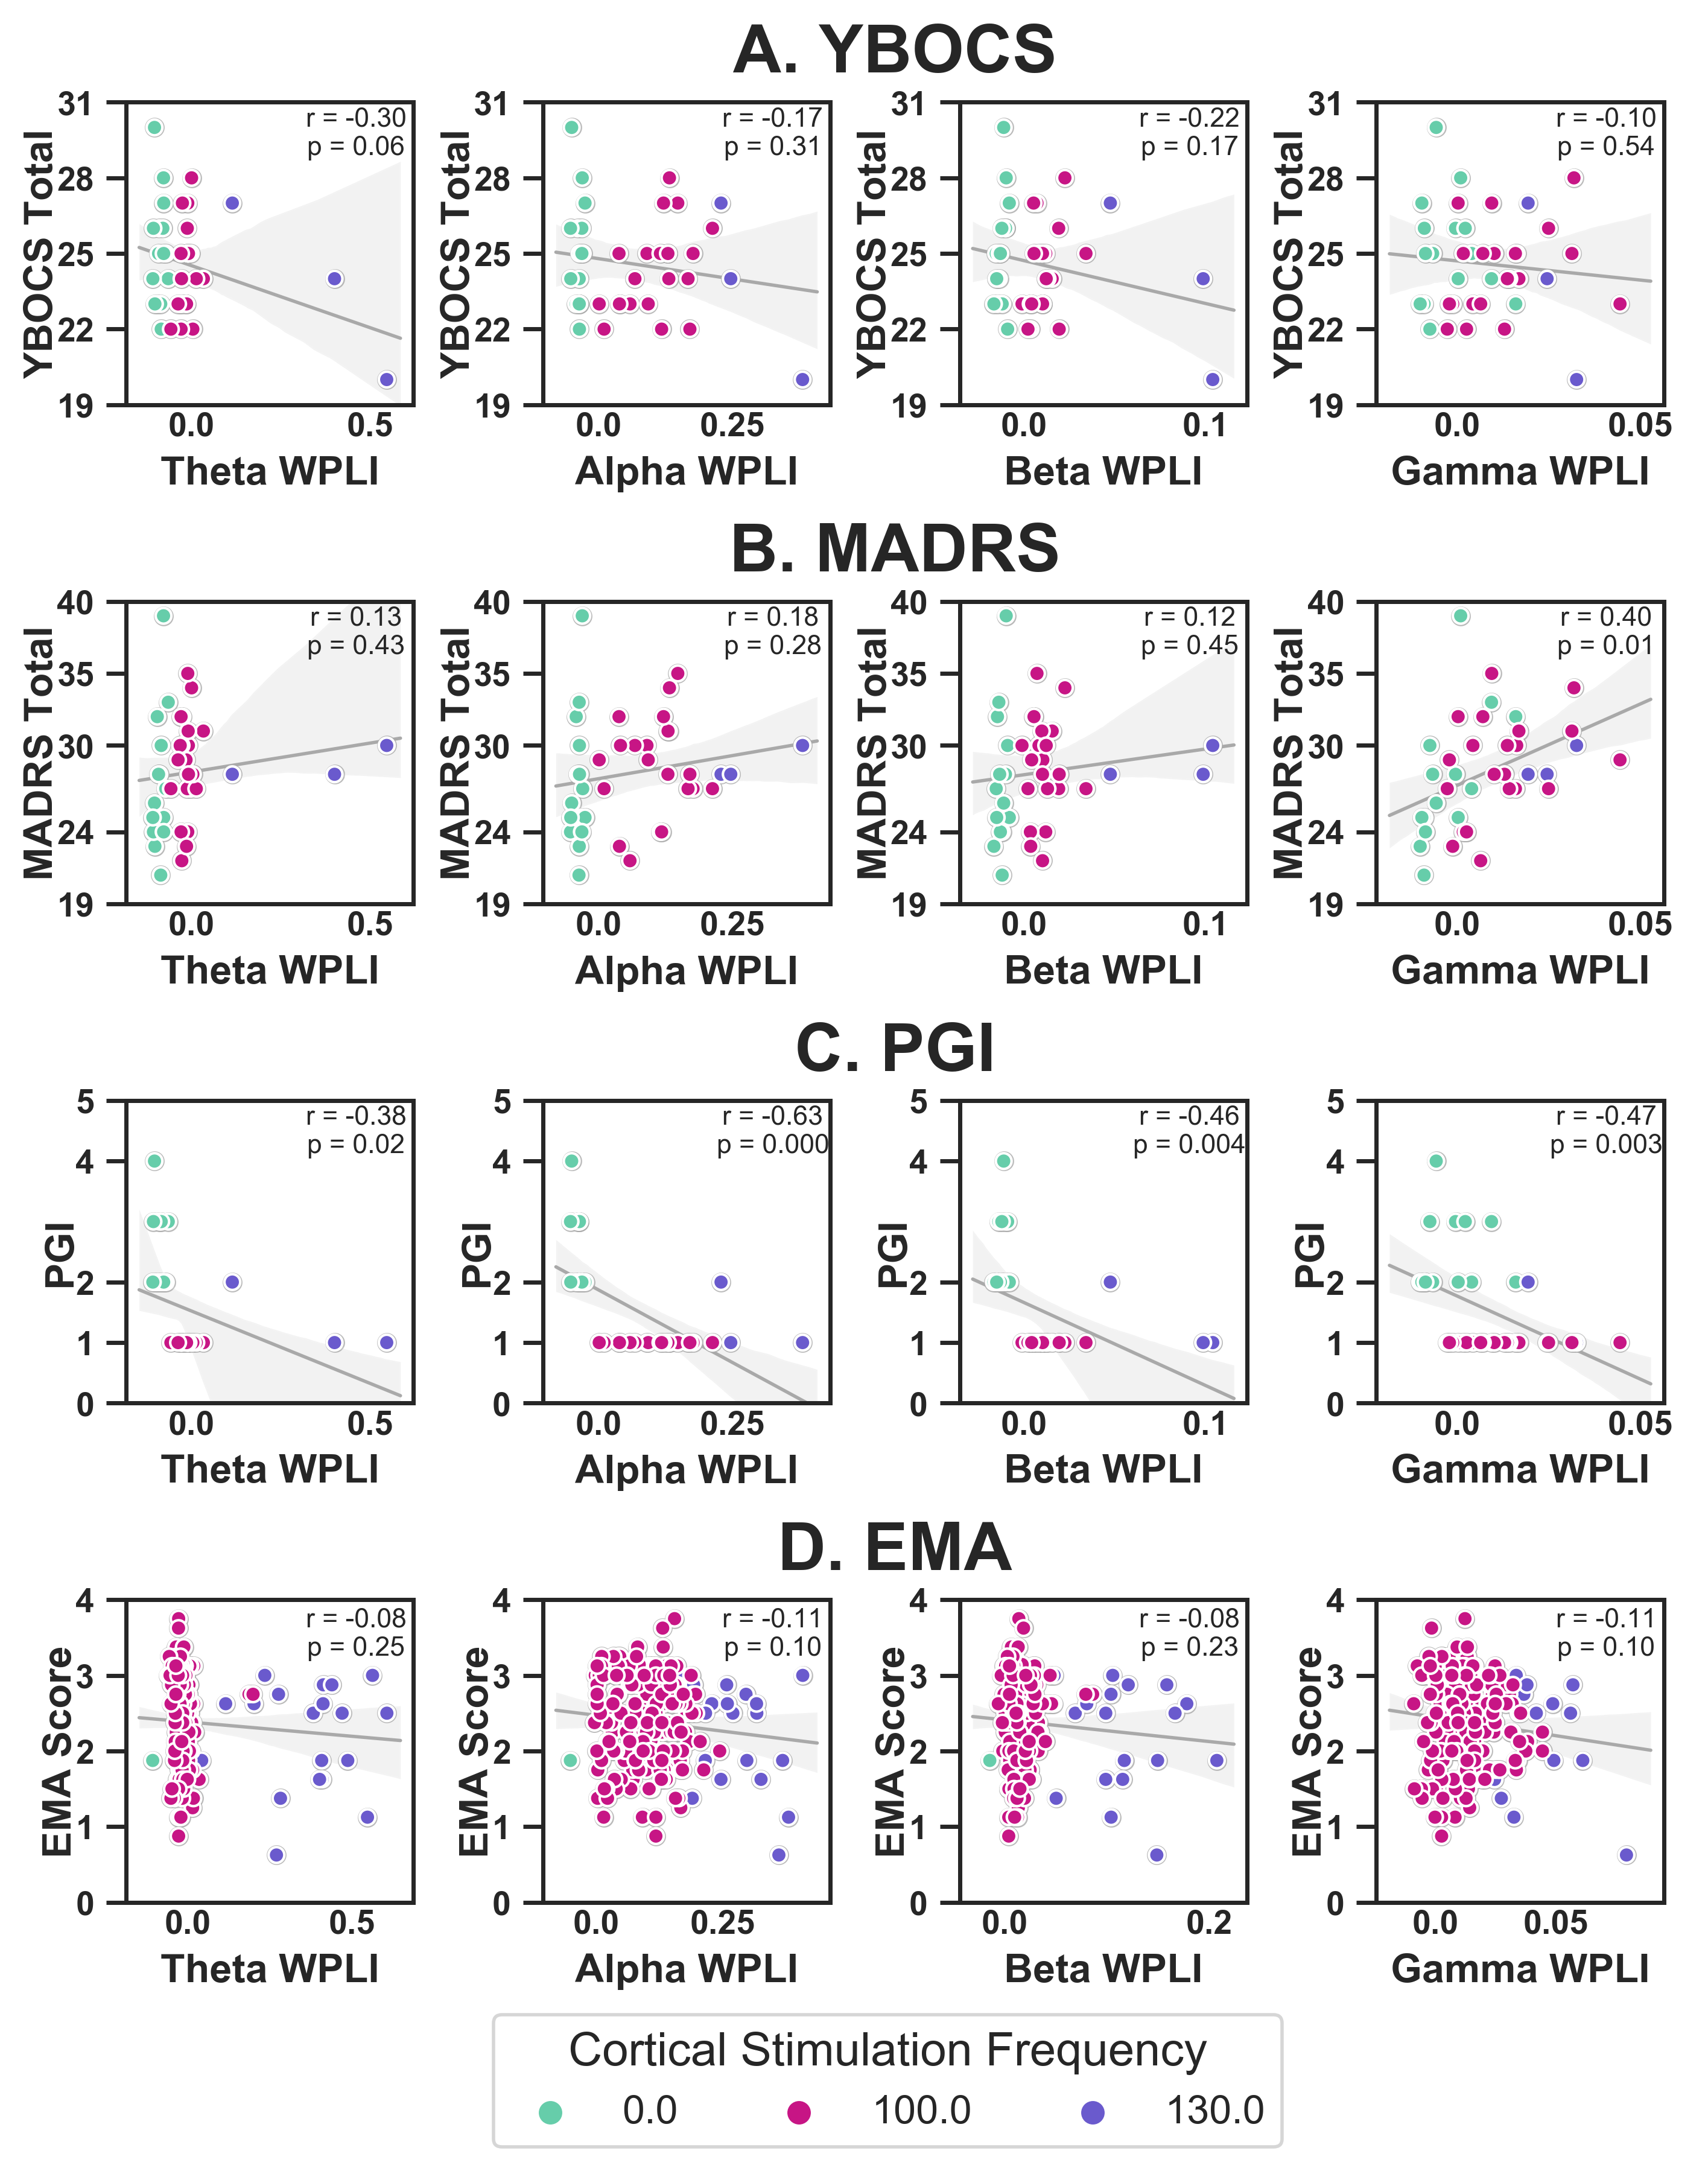

In [45]:
#Make the correlation figure

import matplotlib.gridspec as gridspec

band_list = ['Theta', 'Alpha', 'Beta', 'Gamma']

x_columns = ['avg_ipsi_wpli_closestDayPreClinic_full_day_Theta', 
                                  'avg_ipsi_wpli_closestDayPreClinic_full_day_Alpha', 
                                  'avg_ipsi_wpli_closestDayPreClinic_full_day_Beta', 
                                  'avg_ipsi_wpli_closestDayPreClinic_full_day_Gamma']

freq_column = 'Frequency_CL'


fig = plt.figure(figsize=(7.08, 9.04), dpi=400) #create the figure object

gs = gridspec.GridSpec(4, 1, figure=fig, hspace = .65, bottom=0.125, top=0.95, left=0.08, right=0.98)
         #grid spec allows to create nested subplots, I think it creates a gridspec opject, not technically an axis/subplot

########################
####YBOCS Outcomes###
########################

gs_ybocs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[0, 0], wspace = 0.45) #create the nested subplots, with 1 row and 4 columns

ax_ybocs_00 = fig.add_subplot(gs_ybocs[0, 0]) #assign/name the axes
ax_ybocs_01 = fig.add_subplot(gs_ybocs[0, 1])
ax_ybocs_02 = fig.add_subplot(gs_ybocs[0, 2])
ax_ybocs_03 = fig.add_subplot(gs_ybocs[0, 3])

ax_list = [ax_ybocs_00, ax_ybocs_01, ax_ybocs_02, ax_ybocs_03]  

#create the title on a separate axis
ax_ybocs_Title = fig.add_subplot(gs_ybocs[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_ybocs_Title.set_xticks([])
ax_ybocs_Title.set_yticks([])
plt.text(0.5, 1.1, 'A. YBOCS',
         horizontalalignment='center',
         fontsize=20, fontweight='bold',
         transform = ax_ybocs_Title.transAxes)

y_column = 'YBOCS_total'
y_name = 'YBOCS Total'
ymin = 19
ymax = 31

YBOCS_coh_df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = y_column)
print(YBOCS_coh_df['YBOCS_total'].shape)

corr_df = YBOCS_coh_df
corr_df[freq_column] = corr_df[freq_column].astype(str)

coh_corr_with_quest_byfreq_noleg(corr_df = corr_df, y_column = y_column, y_name = y_name, freq_column = freq_column, 
                               x_columns = x_columns, ymin = ymin, ymax = ymax, band_list = band_list, ax_list=ax_list, directory=directory)


########################
####MADRS Outcomes###
########################
gs_madrs = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[1, 0], wspace = 0.45)

ax_madrs_00 = fig.add_subplot(gs_madrs[0, 0])
ax_madrs_01 = fig.add_subplot(gs_madrs[0, 1])
ax_madrs_02 = fig.add_subplot(gs_madrs[0, 2])
ax_madrs_03 = fig.add_subplot(gs_madrs[0, 3])

ax_list = [ax_madrs_00, ax_madrs_01, ax_madrs_02, ax_madrs_03]

ax_madrs_Title = fig.add_subplot(gs_madrs[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_madrs_Title.set_xticks([])
ax_madrs_Title.set_yticks([])
plt.text(0.5, 1.1, 'B. MADRS',
         horizontalalignment='center',
         fontsize=20, fontweight='bold',
         transform = ax_madrs_Title.transAxes)

y_column = 'MADRS_total'
y_name = 'MADRS Total'
ymin = 19
ymax = 40

MADRS_coh_df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = y_column)
print(MADRS_coh_df['MADRS_total'].shape)

corr_df = MADRS_coh_df
corr_df[freq_column] = corr_df[freq_column].astype(str)

coh_corr_with_quest_byfreq_noleg(corr_df = corr_df, y_column = y_column, y_name = y_name, freq_column = freq_column, 
                               x_columns = x_columns, ax_list = ax_list, ymin = ymin, ymax = ymax, band_list = band_list, directory=directory)


########################
####PGI Outcomes###
########################
gs_pgi = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[2, 0], wspace = 0.45)

ax_pgi_00 = fig.add_subplot(gs_pgi[0, 0])
ax_pgi_01 = fig.add_subplot(gs_pgi[0, 1])
ax_pgi_02 = fig.add_subplot(gs_pgi[0, 2])
ax_pgi_03 = fig.add_subplot(gs_pgi[0, 3])

ax_list = [ax_pgi_00, ax_pgi_01, ax_pgi_02, ax_pgi_03]

ax_pgi_Title = fig.add_subplot(gs_pgi[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_pgi_Title.set_xticks([])
ax_pgi_Title.set_yticks([])
plt.text(0.5, 1.1, 'C. PGI',
         horizontalalignment='center',
         fontsize=20, fontweight='bold',
         transform = ax_pgi_Title.transAxes)

y_column = 'PGI'
y_name = 'PGI'
ymin = 0
ymax = 5

PGI_coh_df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = y_column)
print(PGI_coh_df['PGI'].shape)

corr_df = PGI_coh_df
corr_df[freq_column] = corr_df[freq_column].astype(str)

coh_corr_with_quest_byfreq_noleg(corr_df = corr_df, y_column = y_column, y_name = y_name, freq_column = freq_column, 
                               x_columns = x_columns, ax_list = ax_list, ymin = ymin, ymax = ymax, band_list = band_list, directory=directory)



########################
####EMA Outcomes###
########################
gs_ema = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3, 0], wspace = 0.45)

ax_ema_00 = fig.add_subplot(gs_ema[0, 0])
ax_ema_01 = fig.add_subplot(gs_ema[0, 1])
ax_ema_02 = fig.add_subplot(gs_ema[0, 2])
ax_ema_03 = fig.add_subplot(gs_ema[0, 3])

ax_list = [ax_ema_00, ax_ema_01, ax_ema_02, ax_ema_03]

ax_ema_Title = fig.add_subplot(gs_ema[0, :], frameon=False) #add the title axis (for the title of the nested grid)
ax_ema_Title.set_xticks([])
ax_ema_Title.set_yticks([])
plt.text(0.5, 1.1, 'D. EMA',
         horizontalalignment='center',
         fontsize=20, fontweight='bold',
         transform = ax_ema_Title.transAxes)

y_column = 'Summary Score'
y_name = 'EMA Score'
ymin = 0
ymax = 4

EMA_coh_df = prepare_corr_data(df_full = outcomes_features_df, outcome_name = y_column)
print(EMA_coh_df['Summary Score'].shape)

corr_df = EMA_coh_df
corr_df[freq_column] = corr_df[freq_column].astype(str)

ax2 = coh_corr_with_quest_byfreq_wleg(corr_df = corr_df, y_column = y_column, y_name = y_name, freq_column = freq_column, 
                               x_columns = x_columns, ax_list = ax_list, ymin = ymin, ymax = ymax, band_list = band_list, directory=directory)

#get the legend for the figure
handles, labels = ax2.get_legend_handles_labels()

ax_pos = ax_ema_Title.get_position() # get the original position 
legend_bbox = [-2.2, ax_pos.y0 + -1, 1, 0.2]
ax2.legend(handles=handles[1:], labels=labels[1:], title="Cortical Stimulation Frequency",fontsize=12,title_fontsize=14, loc = 'lower center', ncol=3, markerscale=1, bbox_to_anchor=legend_bbox)

filename = 'Figure 10.jpg'
plt.savefig(figure_dir + filename)
print('Done!')

<h1>Random forest Analysis </h1>
<h2>Random forest regressions predicting clinical outcomes (YBOCS, MADRS, PGI, EMA) using power and WPLI features</h2>

<h2>LOAD AND PREPARE THE DATA FOR RANDOM FOREST</h2>

In [25]:
#Load the the file with the outcomes and features (created in pcs_analysis_and_visualization_01_06_2020)
outcomes_features_file_path = data_dir+'UH3-NS100548-01_PCS01_ClinOutcomes_PowWpliFeatures.csv'
    #set the file path for the outcome_features file file (may need to change if file path changes)
outcomes_features_df = pd.read_csv(outcomes_features_file_path, index_col=False) #load the metadata file as a pandas dataframe
print('Done!')

Done!


In [49]:
#get the list of features to be used in the random forest

#get a list of the relevant stimulation and recording settings columns
settings_cols = ['Cortical Left Ch Center Freq', 'Striatal Left Ch Center Freq', 'Voltage_SL', 'Voltage_SR', 'Voltage_CL', 
                                     'Frequency_CL', 'Voltage_CR', 
                                     'Cortical Left Ch Name_CL0-2', 'Cortical Right Ch Name_CR0-1', 'Cortical Right Ch Name_CR0-2', 
                                     'Cortical Right Ch Name_CR1-2',
                                     'Cortical_On_Off']

first_feature_ix = outcomes_features_df.columns.get_loc('sl_power_twoWkPreClinic_full_day_Theta')
last_feature_ix_plusone = outcomes_features_df.columns.get_loc('right_ipsi_wpli_closestDayPreClinic_evening_Gamma') + 1

LFP_feature_cols = list(outcomes_features_df.columns[first_feature_ix:last_feature_ix_plusone])

feature_cols = settings_cols + LFP_feature_cols

print('Done!')

Done!


In [50]:
def prepare_rf_data(df_full, outcome_name, feature_names):
    
    """Function for extracting the relevant outcomes and features for use in the random forest"""
    
    df = df_full.dropna(how='any', subset=[outcome_name]) #drops the na's, if any from the full dataframe
    df.reset_index(inplace=True, drop = True) #resets the index
    
    #df = df.dropna(how='any') #drops the na's, if any from the full dataframe
    #df.reset_index(inplace=True, drop = True)
    
    outcome = df[outcome_name].values #get the outcome data as a numpy array
    
    features = df[feature_names].values
    
    return outcome, features


<h3>Only run one of these cells depending on which clinical outcome you want to predict.</h3>

In [51]:
#RUN FOR YBOCS!!!

df_full = outcomes_features_df
outcome_name = 'YBOCS_total'
feature_names = feature_cols

outcome, features = prepare_rf_data(df_full, outcome_name, feature_names)

print(outcome.shape)
print(features.shape)

(39,)
(39, 292)


In [ ]:
#RUN FOR MADRS!!!

df_full = outcomes_features_df
outcome_name = 'MADRS_total'
feature_names = feature_cols

outcome, features = prepare_rf_data(df_full, outcome_name, feature_names)

print(outcome.shape)
print(features.shape)

In [ ]:
#RUN FOR PGI!!!

df_full = outcomes_features_df
outcome_name = 'PGI'
feature_names = feature_cols

outcome, features = prepare_rf_data(df_full, outcome_name, feature_names)

print(outcome.shape)
print(features.shape)

In [ ]:
#RUN FOR EMA SCORE!!!

df_full = outcomes_features_df
outcome_name = 'Summary Score'
feature_names = feature_cols

outcome, features = prepare_rf_data(df_full, outcome_name, feature_names)

print(outcome.shape)
print(features.shape)

<h2>RANDOM FOREST PREDICTING CLINICAL OUTCOMES</h2>
<h3>These cells will need to be rerun for each clinical outcome</h3>

In [52]:
#Perform the random forest on all the features using 5-fold cross-validation, and get feature importances

from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.impute import SimpleImputer

print(outcome_name)

#get the random forest model (to be used below)
rnd_forest = ensemble.RandomForestRegressor(n_estimators = 2000, min_samples_split = 2) #this sets the parameters for the random forest model
                                                                                        #n_estimators = number of trees in the forest
                                                                                        #min_samples_split = minimum samples reguired to split the node
                                                                                        #note that max features (i.e. number of features to consider at each split) is set to auto (i.e., n_features)
                                                                                            #not using a random set of features is standard for regression random forests

    
#get the set the kfold splits for cross valudation
cv = KFold(n_splits=5, shuffle=True, random_state=42) 

#get baseline accuracy (average of all the test sets in the k-folds)
baseline_acc = np.empty([5,])
for i, (train_idx, test_idx) in enumerate(cv.split(outcome)):
    #print(train_idx)
    errors_baseline = abs(np.mean(outcome[test_idx]) - outcome[test_idx])
    mape = np.mean(100 * (errors_baseline / outcome[test_idx]))
    accuracy = 100 - mape  
    baseline_acc[i] = accuracy
print('Baseline Accuracy:', round(np.mean(baseline_acc), 2), '%.')

#Replace missing values in the features with the mean for that feature
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(features)

# Impute our data, then train
features_imp = imp.transform(features)

output = cross_validate(rnd_forest, X=features_imp, y=outcome, cv=cv, scoring = 'r2', return_estimator =True)
#print("Cross Validation r^2: %0.2f (+/- %0.2f)" % (output['test_score'].mean(), output['test_score'].std() * 2))

#get the predicted values and find the error of predicted to actual
cv_predicted = cross_val_predict(rnd_forest, X=features_imp, y=outcome, cv=cv)
errors = abs(cv_predicted - outcome)

# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / outcome))
# Calculate and display accuracy
accuracy = 100 - mape

print('Cross Validation Accuracy:', round(accuracy, 2), '%.')
print('Cross validation mean absolute error:', round(np.mean(errors), 2))
print("Cross Validation r^2: %0.2f (+/- %0.2f)" % (output['test_score'].mean(), output['test_score'].std() * 2)) #uses the 'scores' key from cross valudation output

#####get the feature imprtances 
feature_importances = pd.DataFrame() #create and empty dataframe
feature_importances['Feature_name'] = feature_names #add the feature names

for idx,estimator in enumerate(output['estimator']): #for each of the estimators
    importance_col = 'Importance_split_' + str(idx)  #get the column name
    feature_importances[importance_col] = estimator.feature_importances_ #add the feature importances to the importances dataframe

feature_importances['Average Importance'] = feature_importances.mean(axis=1) #get the mean importance for each feature

feature_importances = feature_importances.sort_values('Average Importance', ascending=False) #sort the dataframe based on the average importances
print(feature_importances[['Feature_name', 'Average Importance']])
print(feature_importances)


YBOCS_total
Baseline Accuracy: 93.75 %.
Cross Validation Accuracy: 93.25 %.
Cross validation mean absolute error: 1.64
Cross Validation r^2: -0.14 (+/- 0.35)
                                          Feature_name  Average Importance
108         sl_power_closestDayPreClinic_evening_Theta            0.032477
56                 cl_power_twoWkPreClinic_night_Theta            0.023465
260   left_ipsi_wpli_closestDayPreClinic_morning_Theta            0.023341
111         sl_power_closestDayPreClinic_evening_Gamma            0.022538
58                  cl_power_twoWkPreClinic_night_Beta            0.021427
35              sr_power_twoWkPreClinic_full_day_Gamma            0.020336
240    avg_ipsi_wpli_closestDayPreClinic_morning_Theta            0.018558
146        cl_power_closestDayPreClinic_afternoon_Beta            0.017680
113        sr_power_closestDayPreClinic_full_day_Alpha            0.012496
138            cl_power_closestDayPreClinic_night_Beta            0.012474
115        sr_pow

<h2>PLOT FEATURE IMPORTANCES AND REDO MODEL WITH ONLY TOP FEATURES</h2>

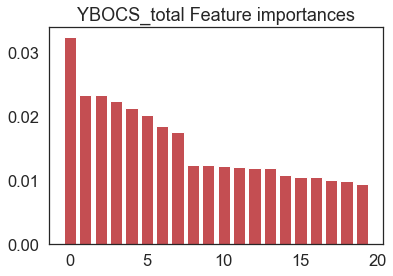

In [54]:
#Plot the top 20 features
filename = figure_dir + outcome_name +'_Feature_Importances_Full_model.png'

#get the top 20 features
feature_importances.reset_index(inplace=True, drop = True)    
importances_top = feature_importances.head(n=20)

# Plot the feature importances of the forest
plt.figure()
plt.title(outcome_name + " Feature importances")
plt.bar(x = range(importances_top['Feature_name'].shape[0]), height = importances_top['Average Importance'],
       color="r", align="center")
plt.savefig(filename, dpi=400) #save the figure
#plt.close()

In [55]:
#Reduce the features and feature names to only the top features

#get the top 5 features
feature_importances.reset_index(inplace=True, drop = True)    
importances_top = feature_importances.head(n=5)

#get list of booleans of the full (unsorted) list of features with true if it matches one of the top features
keep_features = [any(top_feature in feature for top_feature in list(importances_top['Feature_name'].values)) for feature in feature_names]

top_features = features[:,keep_features] #get the the features to only the top features

#get the names of the top features
feature_names_array = np.array(feature_names)
top_feature_names = feature_names_array[keep_features]

print(top_features.shape)
print(top_feature_names)

(39, 5)
['cl_power_twoWkPreClinic_night_Theta'
 'cl_power_twoWkPreClinic_night_Beta'
 'sl_power_closestDayPreClinic_evening_Theta'
 'sl_power_closestDayPreClinic_evening_Gamma'
 'left_ipsi_wpli_closestDayPreClinic_morning_Theta']


In [56]:
#Redo the model with the new, restricted, features set
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, cross_validate
from sklearn import ensemble
from sklearn.utils import shuffle

print(outcome_name)
#get the random forest model (to be used below)
rnd_forest = ensemble.RandomForestRegressor(n_estimators = 2000, min_samples_split = 2) #this sets the parameters for the random forest model
                                                                                        #n_estimators = number of trees in the forest
                                                                                        #min_samples_split = minimum samples reguired to split the node
                                                                                        #note that max features (i.e. number of features to consider at each split) is set to auto (i.e., n_features)
                                                                                            #not using a random set of features is standard for regression random forests

    
#get the set the kfold splits for cross valudation
cv = KFold(n_splits=5, shuffle=True, random_state=42) 

#get baseline accuracy (average of all the test sets in the k-folds)
baseline_acc = np.empty([5,])
for i, (train_idx, test_idx) in enumerate(cv.split(outcome)): 
    #print(train_idx)
    errors_baseline = abs(np.mean(outcome[test_idx]) - outcome[test_idx])
    mape = np.mean(100 * (errors_baseline / outcome[test_idx]))
    accuracy = 100 - mape  
    baseline_acc[i] = accuracy
print('Baseline Accuracy:', round(np.mean(baseline_acc), 2), '%.')

#Replace missing values in the features with the mean for that feature
imp = SimpleImputer(missing_values=np.nan, strategy='mean')
imp = imp.fit(top_features)

# Impute our data, then train
features_imp = imp.transform(top_features)

output = cross_validate(rnd_forest, X=features_imp, y=outcome, cv=cv, scoring = 'r2', return_estimator =True)
#print("Cross Validation r^2: %0.2f (+/- %0.2f)" % (output['test_score'].mean(), output['test_score'].std() * 2))

#get the predicted values and find the error of predicted to actual
cv_predicted = cross_val_predict(rnd_forest, X=features_imp, y=outcome, cv=cv)
errors = abs(cv_predicted - outcome)


# Calculate mean absolute percentage error (MAPE)
mape = np.mean(100 * (errors / outcome))
# Calculate and display accuracy
accuracy = 100 - mape

print('Cross Validation Accuracy:', round(accuracy, 2), '%.')
print('Cross validation mean absolute error:', round(np.mean(errors), 2))
print("Cross Validation r^2: %0.2f (+/- %0.2f)" % (output['test_score'].mean(), output['test_score'].std() * 2)) #uses the 'scores' key from cross valudation output
#print(output['estimator'][0].predict)

#####get the feature imprtances 
top_feature_importances = pd.DataFrame() #create and empty dataframe
top_feature_importances['Feature_name'] = top_feature_names #add the feature names

for idx,estimator in enumerate(output['estimator']): #for each of the estimators
    importance_col = 'Importance_split_' + str(idx)  #get the column name
    top_feature_importances[importance_col] = estimator.feature_importances_ #add the feature importances to the importances dataframe

top_feature_importances['Average Importance'] = top_feature_importances.mean(axis=1) #get the mean importance for each feature

top_feature_importances = top_feature_importances.sort_values('Average Importance', ascending=False) #sort the dataframe based on the average importances
print(top_feature_importances[['Feature_name', 'Average Importance']])


YBOCS_total
Baseline Accuracy: 93.75 %.
Cross Validation Accuracy: 93.92 %.
Cross validation mean absolute error: 1.48
Cross Validation r^2: 0.15 (+/- 0.19)
                                       Feature_name  Average Importance
1                cl_power_twoWkPreClinic_night_Beta            0.237523
0               cl_power_twoWkPreClinic_night_Theta            0.224462
4  left_ipsi_wpli_closestDayPreClinic_morning_Theta            0.190070
3        sl_power_closestDayPreClinic_evening_Gamma            0.175843
2        sl_power_closestDayPreClinic_evening_Theta            0.172102
